In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
import numpy as np
import tellurium as te
import os
import pickle
import seaborn as sns
import matplotlib.gridspec as gridspec
import sys
import seaborn as sns
sys.path.append('../Estimation/')
from run_estimation import get_params_bounds

/usr/lib/python3/dist-packages/pyDOE/doe_factorial.py:192: SyntaxWarning:

invalid escape sequence '\-'



In [2]:
# Set Matplotlib rcParams to configure line widths globally
mpl.rcParams['lines.linewidth'] = 2  # Line width for all lines
mpl.rcParams['axes.linewidth'] = 2   # Line width of axes
mpl.rcParams['xtick.major.width'] = 2  # Line width of major x-ticks
mpl.rcParams['xtick.minor.width'] = 2  # Line width of minor x-ticks
mpl.rcParams['ytick.major.width'] = 2  # Line width of major y-ticks
mpl.rcParams['ytick.minor.width'] = 2  # Line width of minor y-ticks
#mpl.rcParams['font.weight'] = 'bold'

In [3]:

def load_file(file_loc: str):
    '''
    Function to load file either json or pickled .txt
    ---------------------------------------------------
    Parameter:
    file_loc: str path to file
    ---------------------------------------------------
    returns:
    data: either unpickled tuple or list 
    '''
    if file_loc.endswith('.txt'):
            with open(file_loc, 'rb') as g:
                # data = tuple with [0]=score, [1]=parameter_dict
                data = pickle.loads(g.read())
    else:
        with open(file_loc, 'r') as g:
            # data = list with [0]=score, [1]=parameter_dict
            data = json.loads(g.read())

    return data

def get_parameter_sets(d_path, dir, best:bool = False):
    '''
    Description: function to find the best scoring parameter set for specified model
    -----------
    Parameter:
    d_path: pathway to directory with parameter sets
    n_sets: number of best sets 
    best:   bool if only best parameter set is returned as dict 
    ----------
    returns:
    dresults: pd.DataFrame() with best score as name and parameter names as index
    '''
    d_path = d_path+f'/{dir}'
    files = os.listdir(d_path)
    files = [file for file in files if '.json' in file]
    
    dresults = pd.DataFrame()
    for file in files:
        filename = file
        path = d_path+'/'
        
        data = load_file(path+filename)
        #print(data["update_parameters"])
        # add score to dict for later use
        #data[1]['score'] = data[0]
        dnew = pd.DataFrame.from_dict(data["update_parameters"], orient='index',columns=['Value'])
        # dataframe with each colume parameter set of estimation and name = score 
        dresults[str(data["best_score"])] = dnew['Value']
    # sort the colums names to find lowest estimation score   
    results = sorted(list(map(float, dresults.columns.to_list())))
    results = np.asarray(results,dtype=str)
    if best:
        print(f'Best score={results[0]}')
        
        return dresults[results[0]].to_dict()
    return dresults

def get_border_dict():
    borders = {}
    for name in ['general', 'Hapto','immune']:
        borders.update(get_params_bounds(name))
    
    return borders

def plot_each_parameter(df, border,str_pth):
    
    data = df.T
    params = df.T.columns.tolist()

    for para in params: 

        has_borders = para in border.keys() or para+str_pth in border.keys()
        
        border_name = para
        if para+str_pth in border.keys():
            border_name=para+str_pth

        gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1], wspace=0)
        # Create a new figure and GridSpec layout
        fig = plt.figure(figsize=(4, 3))

        # Boxplot section (top-left)
        ax_boxplot = fig.add_subplot(gs[0])

        # Plot boxplots for params_group1
        data[[para]].boxplot(ax=ax_boxplot, vert=True, 
                            showmeans=True, meanline=True, showfliers=False, patch_artist=True, #notch=True,
                            boxprops=dict(linewidth=0, facecolor='lightgrey'), medianprops=dict(linewidth=2),
                            whiskerprops=dict(ls='dotted', linewidth=2), capprops=dict(linewidth=2),
                            flierprops=dict(markersize=8), meanprops=dict(linewidth=2))
        #if has_borders:
        #    fig.suptitle(f'Boxplot estimation values of {para}')
        #else:
        #    fig.suptitle(f'Boxplot calculated values of {para}')
    
        ax_boxplot.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.3g}'))
        ax_boxplot.grid(False)
        # Add median, mean and values to legend
        handles, labels = ax_boxplot.get_legend_handles_labels()
        
        median_handle = plt.Line2D([0], [0], color='#ff7f0e', linewidth=2, label='Median')
        mean_handle = plt.Line2D([0], [0], ls='--', color='#2ca02c', linewidth=2, label='Mean')
        data_handle = plt.Line2D([0],[0], markersize=4,marker='.', c='r', alpha=0.5, label='Values', lw=0)
        
        handles.extend([median_handle, mean_handle, data_handle])
        
        # Add border if exists to legend
        if has_borders: 
            border_handle = plt.Line2D([0], [0], ls='--', color='red', linewidth=2, label='Borders')
            handles.extend([border_handle])
                
        # Line plot section (top-right)
        ax_lineplot = fig.add_subplot(gs[1])
        log = False

        if has_borders:
            # Plot line plot for borders
            for param, (lower, upper, log) in border.items():
                if border_name == param:
                    # Plot hlines for parameter bounds  
                    ax_lineplot.axhline([lower], linewidth=2, xmin=0.25, xmax=.75,color='r', ls="--")
                    ax_lineplot.axhline([upper], linewidth=2, xmin=0.25, xmax=.75,color='r', ls="--")
                    # Plot boxplot again for better understanding
                    data[[para]].boxplot(ax=ax_lineplot, vert=True, 
                                        showmeans=True, meanline=True, showfliers=False, patch_artist=True, #notch=True,
                                        boxprops=dict(linewidth=0, facecolor='lightgrey'), medianprops=dict(linewidth=2),
                                        whiskerprops=dict(ls='dotted', linewidth=2), capprops=dict(linewidth=2),
                                        flierprops=dict(markersize=3), meanprops=dict(linewidth=2))
                    
        #make red dots and lable each data point
        for i in range(len(data[[para]])):
            y = data[[para]].iloc[i]
            # Add some random "jitter" to the x-axis
            jitter = 0.002
            if has_borders: jitter=0.04
            x = np.random.normal(1, jitter, size=len(y))
            ax_lineplot.plot(x, y, 'r.', alpha=0.5, markersize=4)
            # add label to dot
            #for ids, txt in enumerate(y):
                #_ = plt.text(x[ids]+0.03*x[ids], y[ids]-0.01*y[ids],ids)
        
        # Adjust plot
        if not has_borders:
            ax_lineplot.set_xlim(.98,1.02)

        # Formatting for the line plot OBJECT   
        if log: ax_lineplot.set_yscale('log')
        else: ax_lineplot.set_yscale('linear')    

        say = ax_lineplot.secondary_yaxis('right')
        say.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.3g}'))
        
        ax_lineplot.grid(False)
        ax_lineplot.yaxis.set_visible(False)
        ax_lineplot.xaxis.set_visible(False)
        
        # Adjust spacing of legend
        x_anchor = -3.5
        if not has_borders: x_anchor=-2.75
        # Add legend 
        plt.legend(handles=handles, ncols=len(handles), bbox_to_anchor=(x_anchor, 1),loc='lower left', fontsize='small')
        
        #plt.tight_layout()

        plt.show()

In [4]:
def extract_patient_fitting_data(df: pd.DataFrame, features: list=['Hb', 'LDH'], patient_num=20):
 
    patient_df = df[df['patientnumber']==str(patient_num)]
    fitting_df = patient_df[['time'] + features]
    # Change naming to fit estimation.py cost function
    features_fit = [x+"_mean" for x in features]
    fitting_df.columns = ['Time'] + features_fit
    #print(fitting_df)
    return fitting_df

def load_data(patient_n = 0):
    if patient_n!= 0:
        patient_num  = patient_n
        df = pd.read_csv('../datasets/OIE_data.csv')
        #print(df)
        dpatient_fitting = extract_patient_fitting_data(df, features=['Hb', 'LDH', '[R]'], patient_num=patient_num)
        data = {"pth":dpatient_fitting,       
                "non":dpatient_fitting}
    else:
        print('No patient')
        data = {"pth":pd.read_csv("../Estimation/pth.csv"),       
                "non":pd.read_csv("../Estimation/non_pth.csv")}
        
    return data

class FitManager():

    def __init__(self, patient_num, name) -> None:
        self.model =  te.loada(f'../LCT_model/{name}_LCT_OIE.ant')
        self.data = load_data(patient_num)
        self.default_pre_t = 10
        self.model_name = name


    def objective_function(self, pars, keys):

        sys.path.append('../Estimation/')
        from estimation import set_model_to_ss

        if 'pre_t' in pars:
            pre_t = pars['pre_t']
            del pars['pre_t']
        else:
            pre_t = self.default_pre_t
        
        # from here loop over data set keys for both models
        score_d = {}
        for key in [keys]:

            usedpars = {k.replace("_"+key,""):v for k,v in pars.items() if key in k or not k.split('_')[-1] in keys}

            # set model to steady state
            self.model = set_model_to_ss(self.model, usedpars, self.model_name)
            
            # simulate 
            t_max = self.data[key]['Time'].max()
            species = ['time', 'Hb', '[LDH]', '[R]']
            #if self.model_name == 'immune':
            #    species = ['time', 'Hb', '[LDH]', '[R]','[Treg]','[Ttox]']
            res = self.model.simulate(-pre_t, int(t_max), int(t_max + pre_t + 1),
                                      selections=species)
            res_df = pd.DataFrame(res, columns=res.colnames)
            #if self.model_name == 'immune':
                #t_reg_error = sum(abs(res_df['[Treg]'].values[0]-[500])/500,abs(res_df['[Treg]'].values[-1] -[500])/500)
                #t_tox_error = sum(abs(res_df['[Ttox]'].values[0]-[500])/500,abs(res_df['[Ttox]'].values[-1] -[500])/500)
                #error_sum += t_reg_error.sum() + t_tox_error.sum()
            # only keep timepoints which are in data
            res_df = res_df[res_df['time'].isin(self.data[key]['Time'])]
            # TODO: loop over data columns?
            Hb_error = ((self.data[key]['Hb_mean'].values - res_df['Hb'].values) 
                        / (self.data[key]['Hb_mean'].max() - self.data[key]['Hb_mean'].min()))**2
            LDH_error = ((self.data[key]['LDH_mean'].values - res_df['[LDH]'].values )  
                         / (self.data[key]['LDH_mean'].max() - self.data[key]['LDH_mean'].min()))**2
            R_error = ((self.data[key]['[R]_mean'].values - res_df['[R]'].values )  
                       / (self.data[key]['[R]_mean'].max() - self.data[key]['[R]_mean'].min()))**2
            
            self.model.resetToOrigin()
            # print(Hb_error.sum(), LDH_error.sum())
            # weighted sum -> works better
            # patient specific data has nan values
            
            score_d[key] = np.nansum(Hb_error) + np.nansum(LDH_error) + 10*np.nansum(R_error)        
        return score_d
    

In [5]:
border = get_border_dict()

In [6]:
path = '../Estimation/'
dir_locs = ['general', 
            'Hapto', 
            'immune']
pth_ar = []
for i,dir in enumerate(dir_locs):
    pth_ar.append(get_parameter_sets(path+dir, 'pth'))
    for key in ['non_pth', 'pth']:
        key1 = key
        if key == 'non_pth':
            key1 = 'non'
        print(FitManager(0, dir).objective_function(get_parameter_sets(d_path='../Estimation/'+dir, dir=key, best=True), key1))

No patient
Best score=0.9209727290411835
{'non': 0.41246285597863364}
No patient
Best score=0.9209727290411835
{'pth': 0.5085098730625499}
No patient
Best score=0.90942537882604
{'non': 0.4193114163858342}
No patient
Best score=0.90942537882604
{'pth': 0.4901139624402059}
No patient
Best score=0.46201015880831225
{'non': 0.23082837822846813}
No patient
Best score=0.46201015880831225
{'pth': 0.23118178057984412}


In [7]:
len(pth_ar)

3

Index(['LDH_RBC', 'fac_R_d', 'k_E_infect', 's_BH', 'k_iE_pit_frac',
       'slope_rpi', 'r_P_d', 'k_P_art_max', 't_mat_P', 'k_P_d', 'tropism',
       'k_M_death', 't_E_death', 'LDH', 'k_P_birth', 'P', 'M', 'R', 'a_P_d',
       'E'],
      dtype='object')


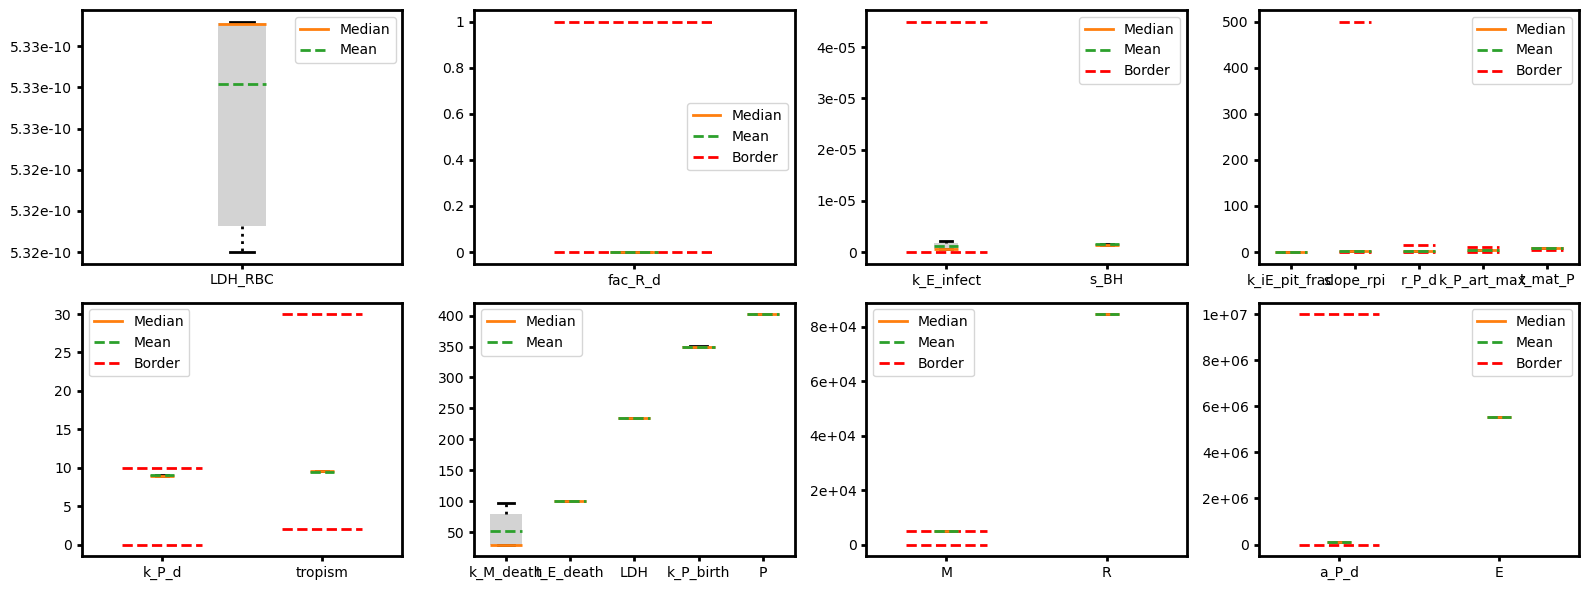

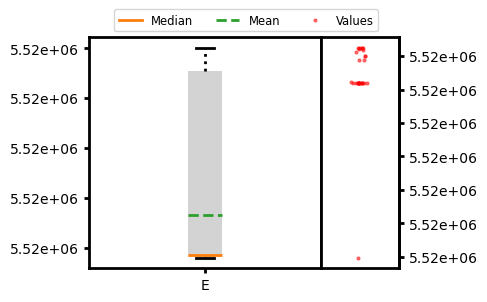

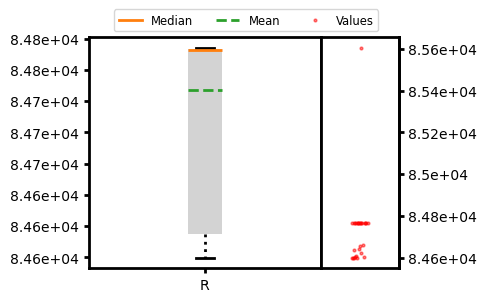

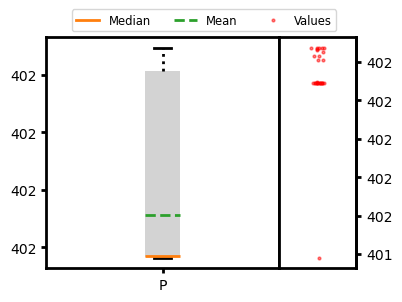

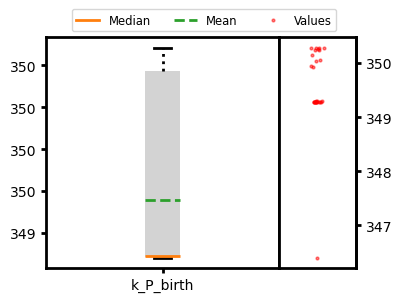

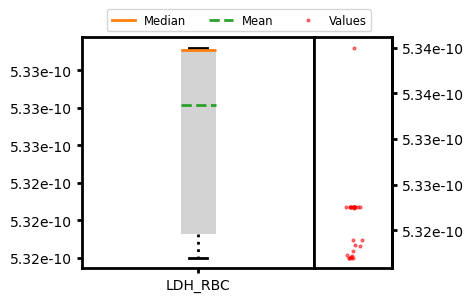

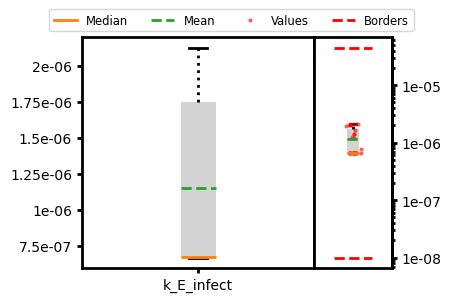

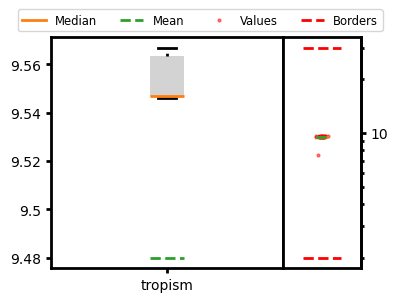

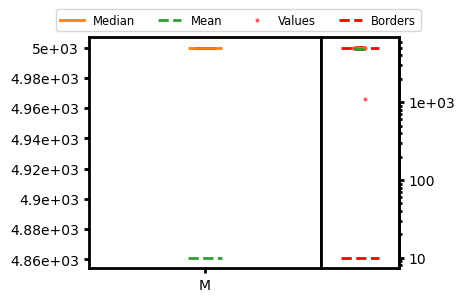

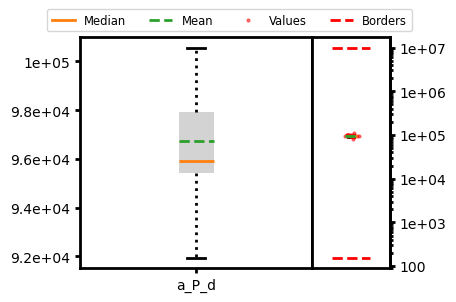

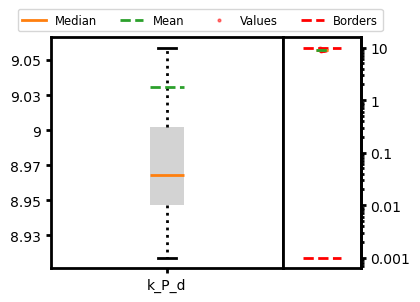

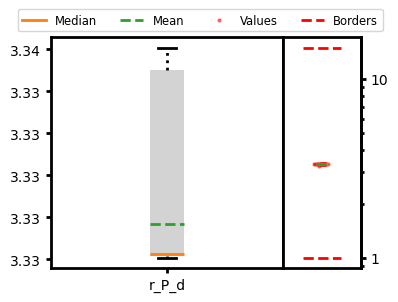

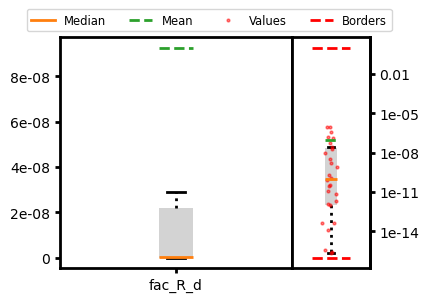

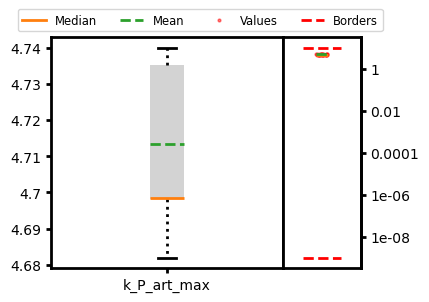

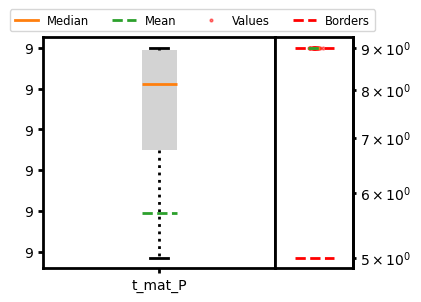

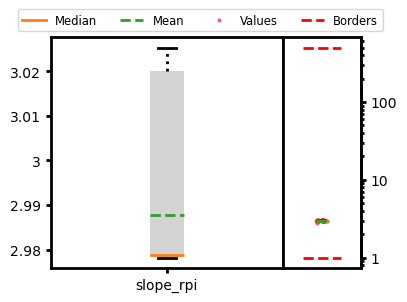

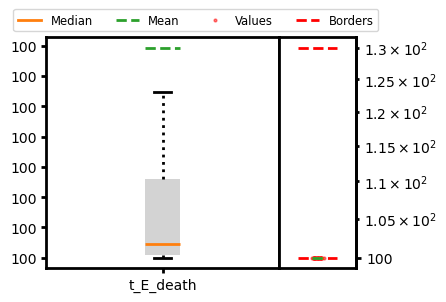

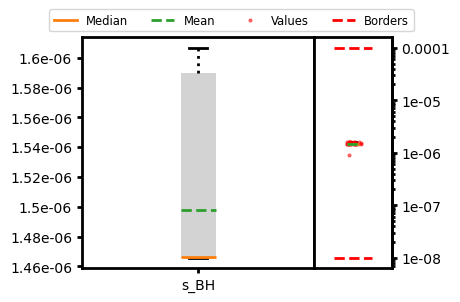

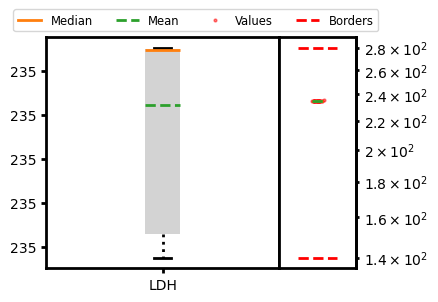

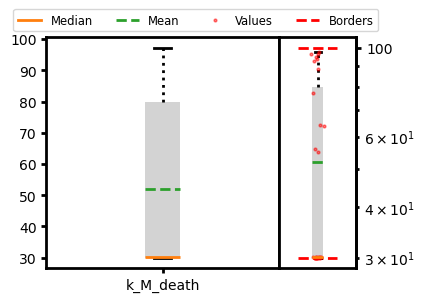

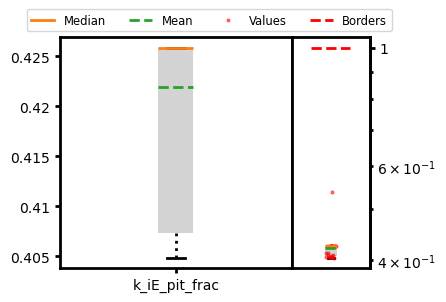

Index(['LDH_RBC', 'k_E_infect', 's_BH', 'par2_fHb', 't_halb_HCC_decay',
       'fac_R_d', 'k_iE_pit_frac', 'r_P_d', 't_halb_HP_decay', 'k_P_art_max',
       'slope_rpi', 'tropism', 't_mat_P', 'k_P_d', 'k_M_death', 't_E_death',
       'LDH', 'k_P_birth', 'P', 'M', 'switch_fHb', 'par1_fHb', 'a_P_d', 'R',
       'E'],
      dtype='object')


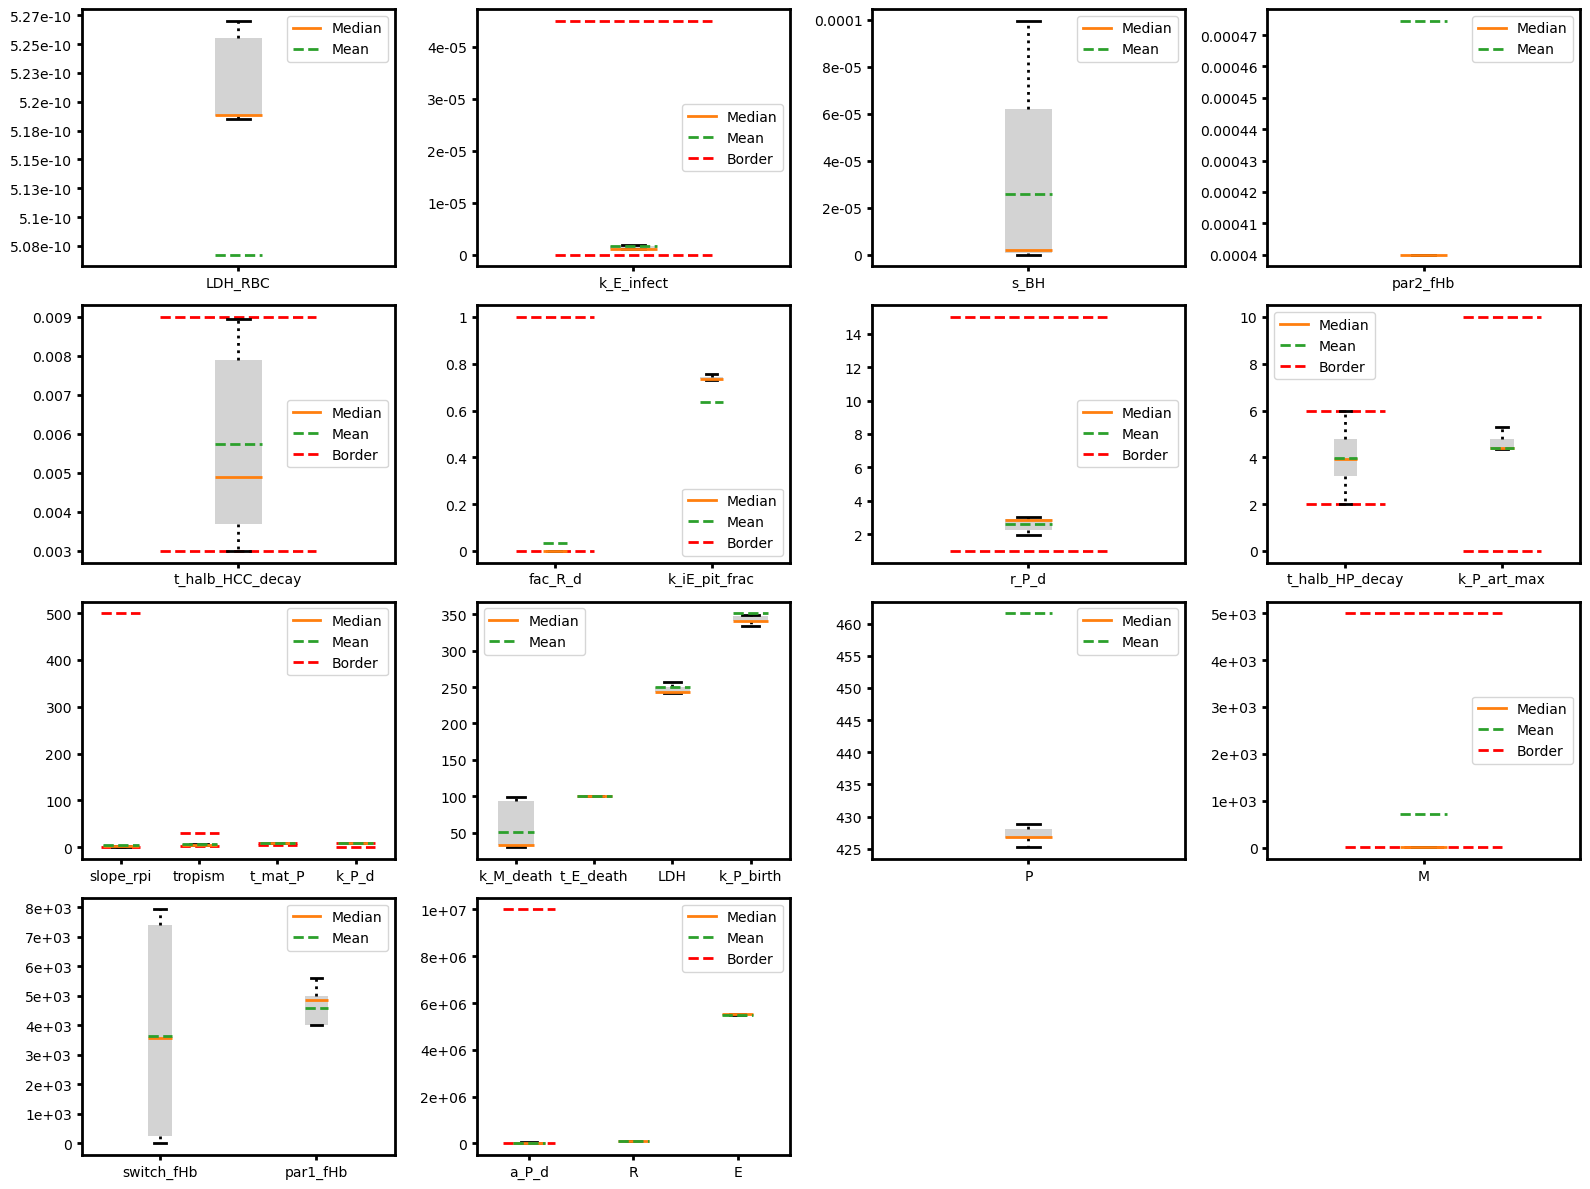

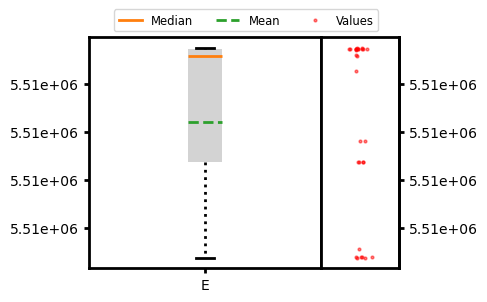

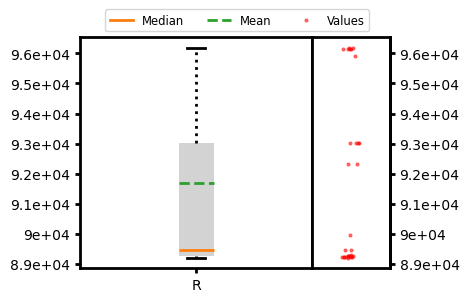

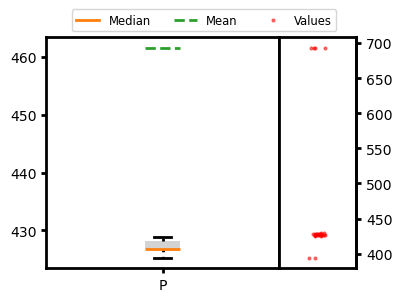

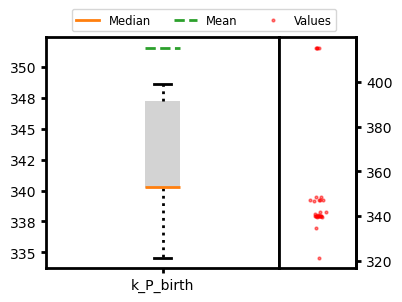

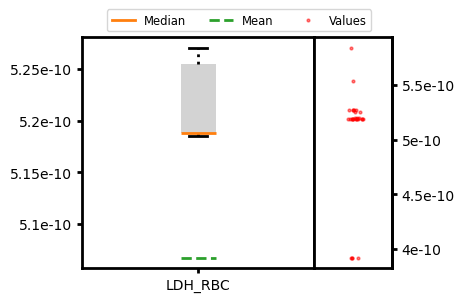

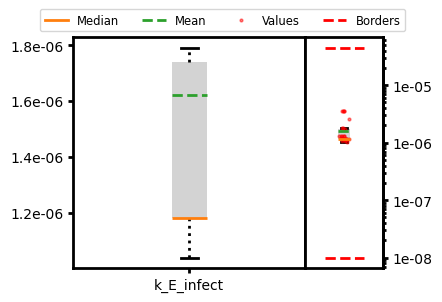

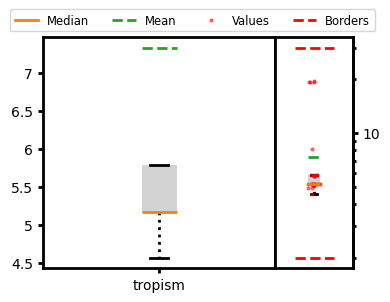

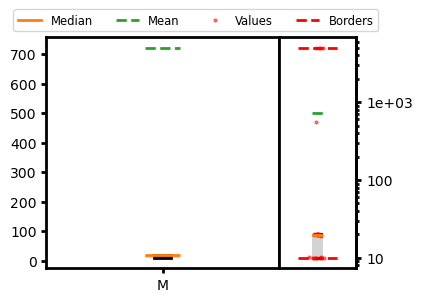

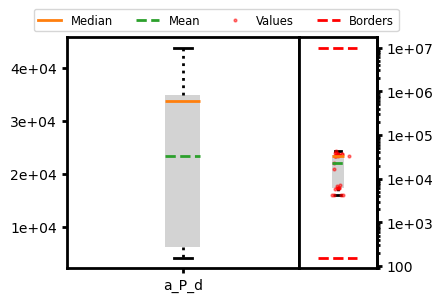

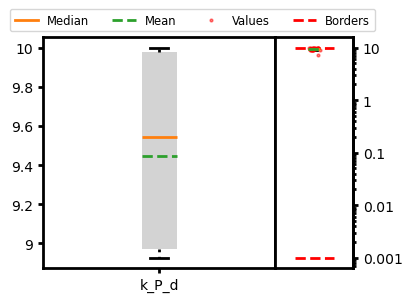

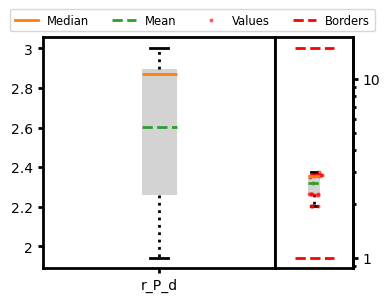

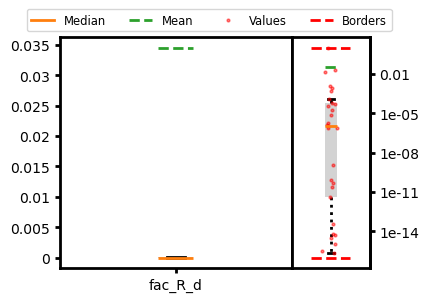

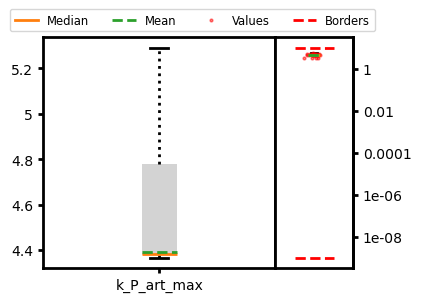

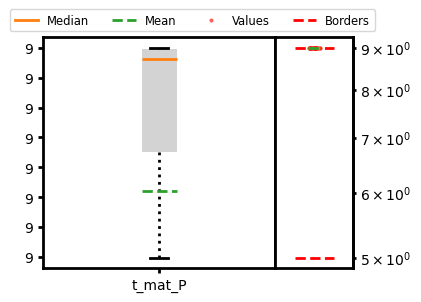

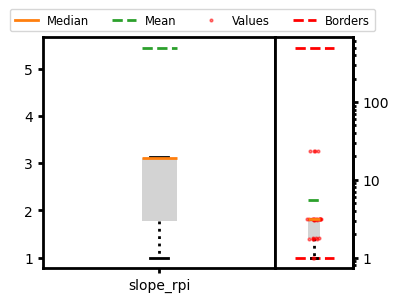

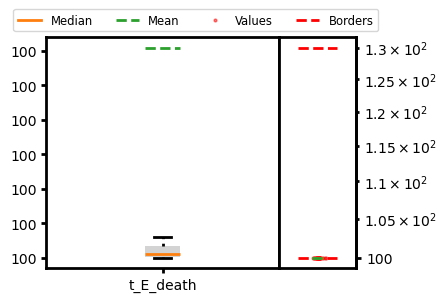

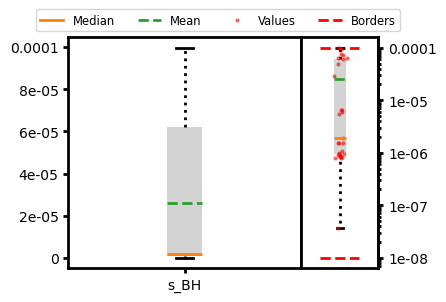

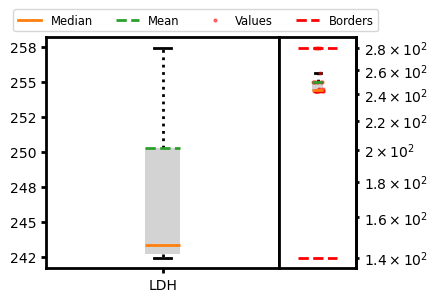

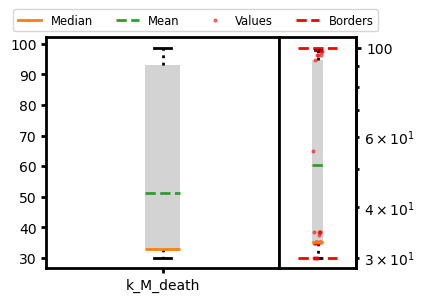

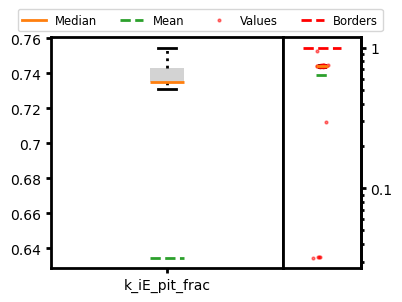

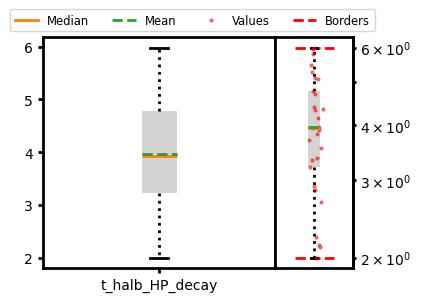

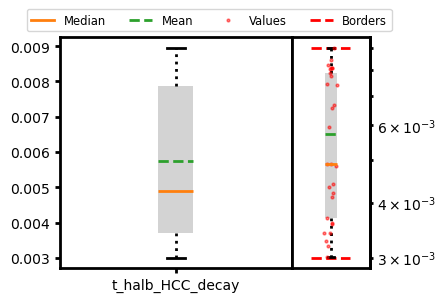

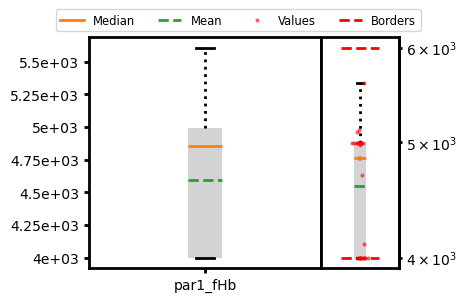

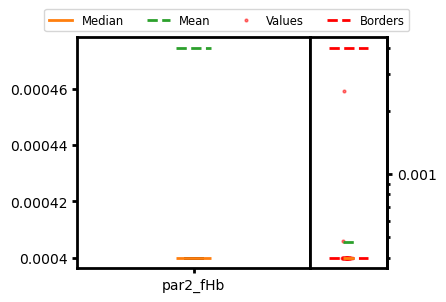

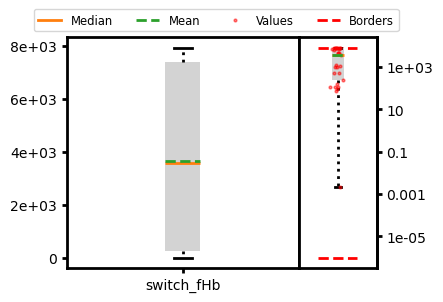

Index(['k_digest_R', 'LDH_RBC', 'k_digest_E', 'epsilon', 'k_E_infect',
       'fac_R_d', 'k_digest_iE', 'beta_Treg', 'beta_in_Treg', 'mu_tox',
       'delta_Ttox', 'V_f', 'k_iE_pit_frac', 'k_P_d', 'slope_rpi',
       'k_P_art_max', 'tropism', 'r_P_d', 't_mat_P', 'M', 'K_f', 'k_M_death',
       'delta_Treg', 'mu_in_tox', 't_E_death', 'LDH', 'P', 'k_P_birth', 'Treg',
       'Ttox', 'R', 'a_P_d', 'E'],
      dtype='object')


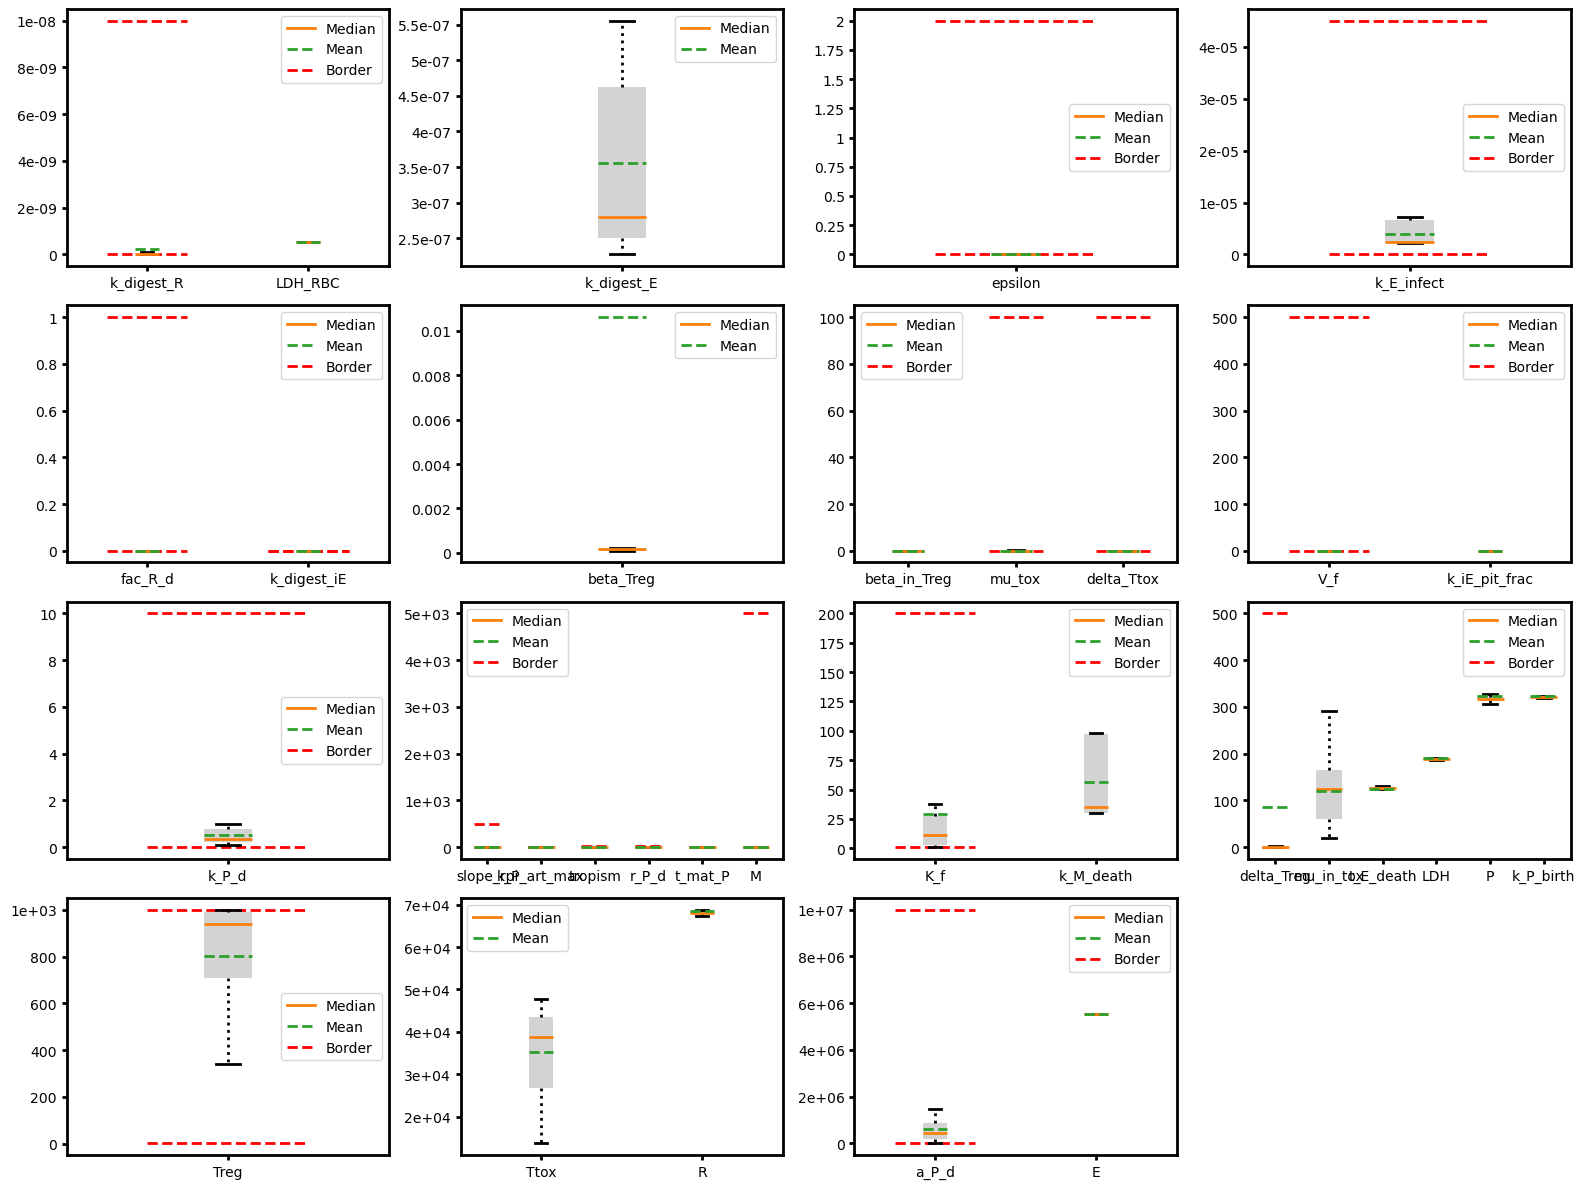

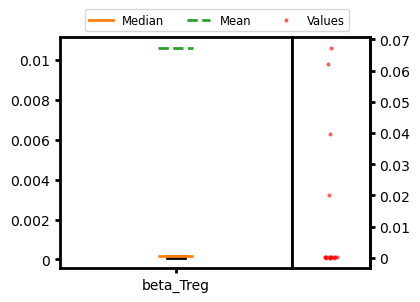

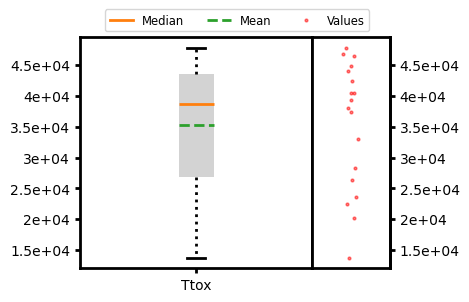

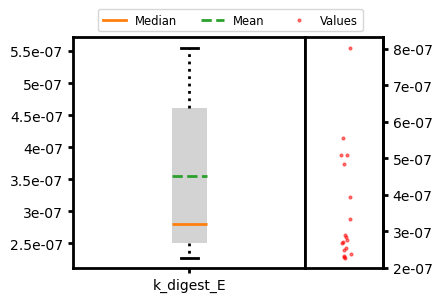

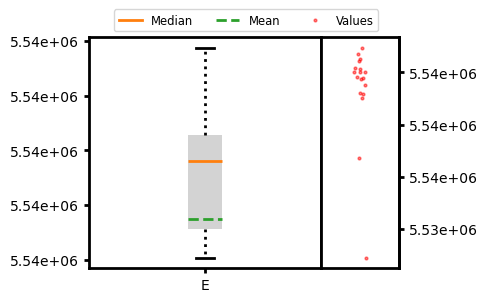

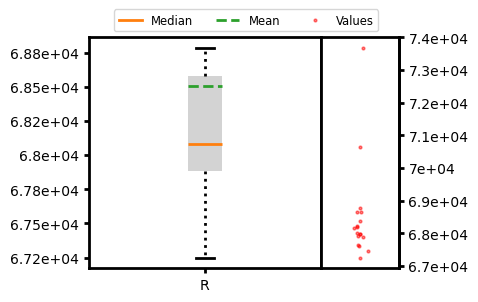

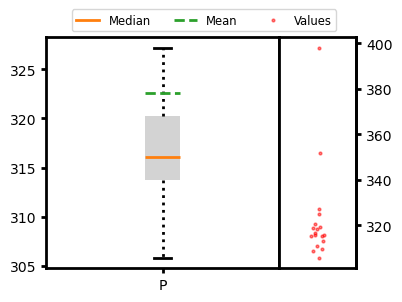

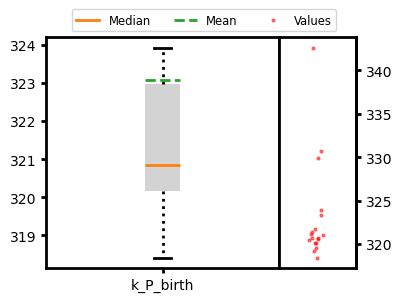

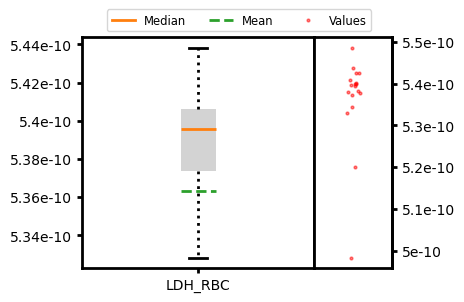

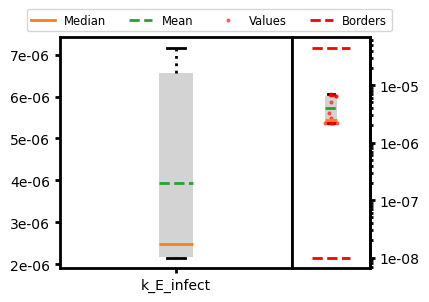

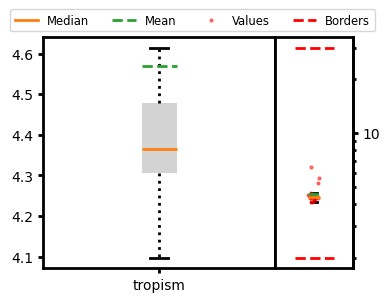

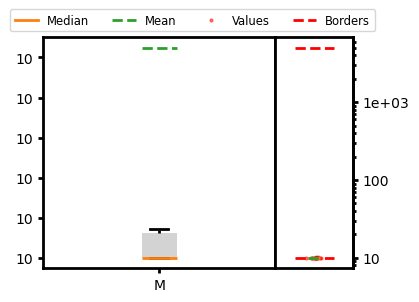

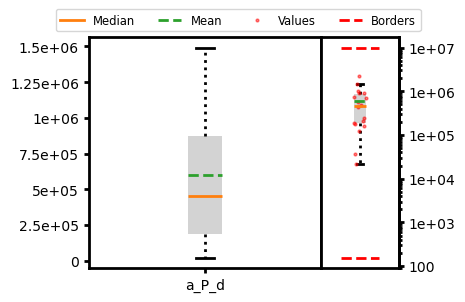

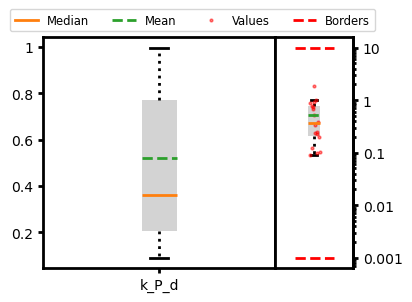

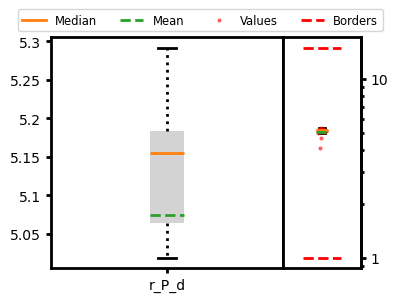

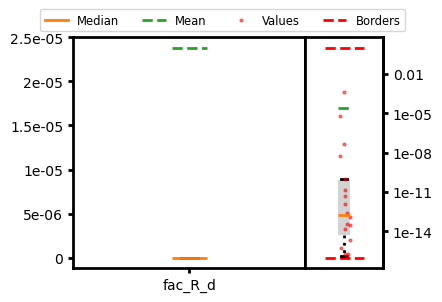

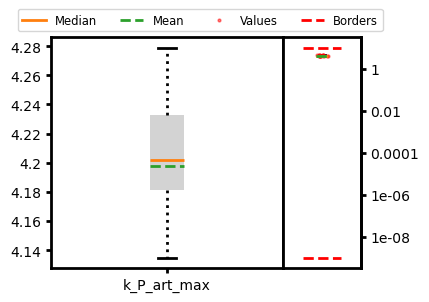

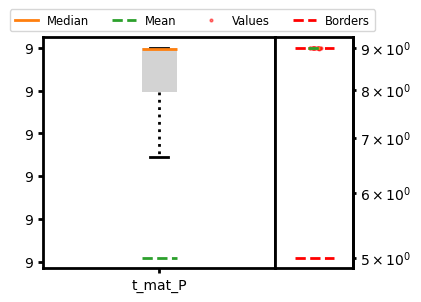

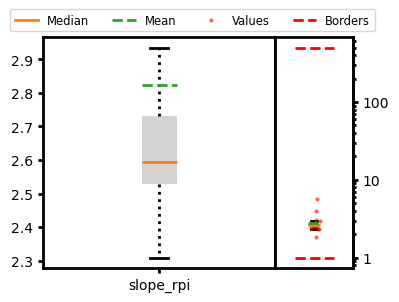

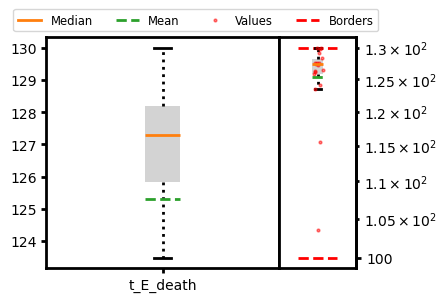

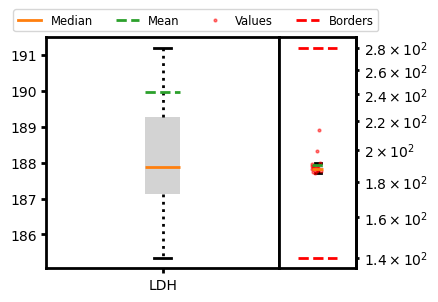

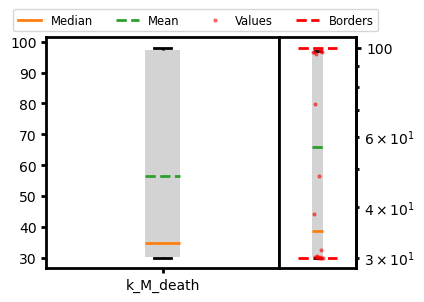

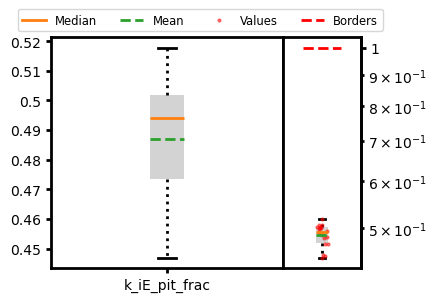

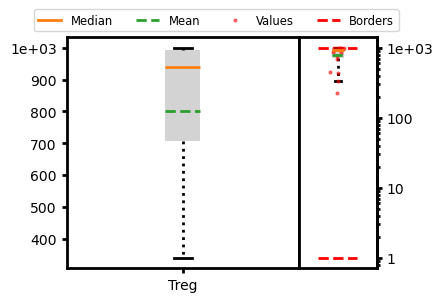

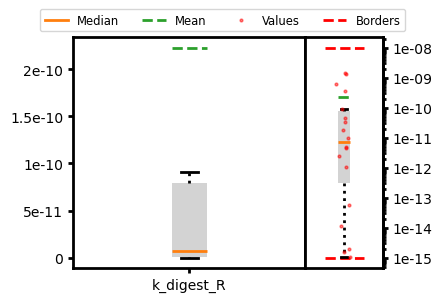

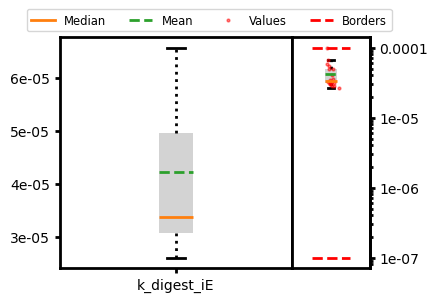

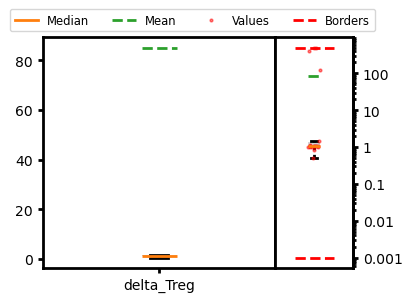

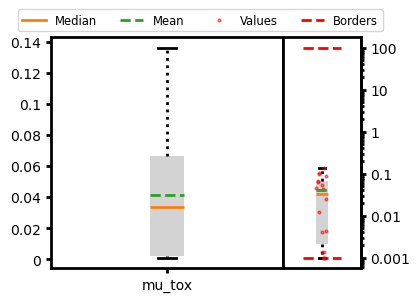

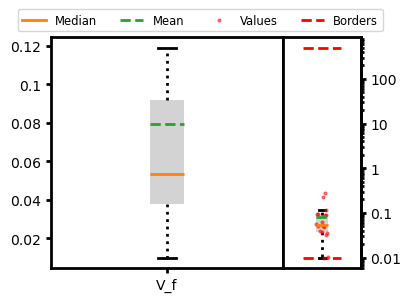

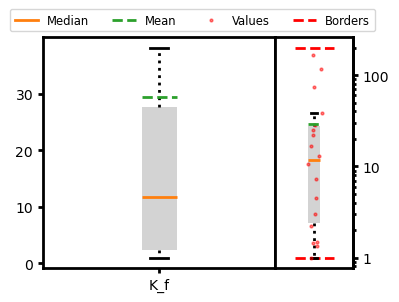

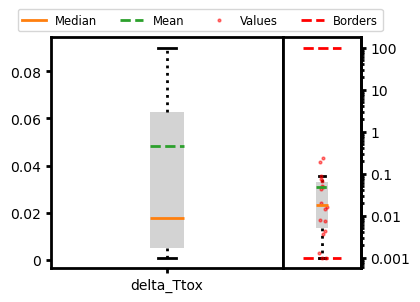

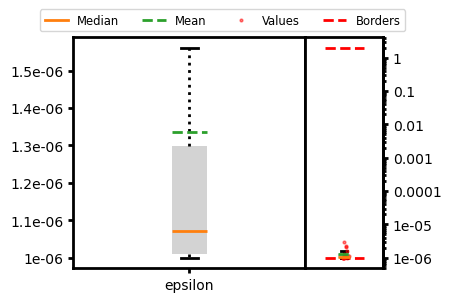

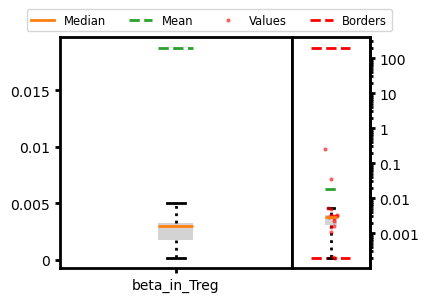

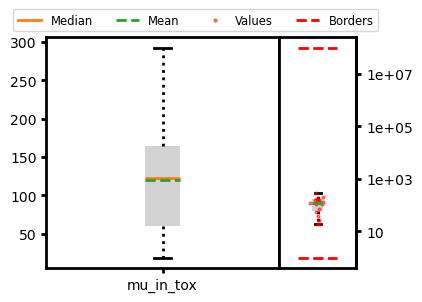

In [8]:
# Function to categorize columns based on data range
def categorize_columns(df):
    column_means = df.mean()
    sorted_columns = column_means.sort_values().index
    print(sorted_columns)
    column_groups = []
    current_group = []
    current_max = df[sorted_columns[0]].max()
    
    for col in sorted_columns:
        if (df[col].max() - df[col].min()) > current_max:
            column_groups.append(current_group)
            current_group = [col]
            current_max = df[col].max()
        else:
            current_group.append(col)
    
    if current_group:
        column_groups.append(current_group)
    
    return column_groups


for dfp in pth_ar: 
    df = dfp.T
    # Get column groups based on data ranges
    column_groups = categorize_columns(df)

    # Plotting boxplots in subplots
    n_cols = 4
    n_rows = int(np.ceil(len(column_groups)/n_cols))  

    fig, axes = plt.subplots(n_rows, n_cols, squeeze=True, figsize=(n_cols*4, n_rows*3))

    meanlineprops = dict(linewidth=2)
    for i, columns in enumerate(column_groups):
        df_boxplot = df[columns]
        ax = axes.flatten()[i]
        bool_border = False
        for j, col in enumerate(columns):
            if col in border.keys():
                ax.axhline(border[col][0], linewidth=2, xmin=(j+0.25) / len(columns),
                        xmax=(j + .75) / len(columns),color='r', ls="--")
                ax.axhline(border[col][1], linewidth=2, xmin=(j+0.25) / len(columns),
                        xmax=(j + .75) / len(columns),color='r', ls="--")
                bool_border = True
                
        bp = df_boxplot.boxplot(ax=ax, vert=True, 
                        showmeans=True, meanline=True, showfliers=False, patch_artist=True, #notch=True,
                        boxprops=dict(linewidth=0, facecolor='lightgrey'), medianprops=dict(linewidth=2),
                        whiskerprops=dict(ls='dotted', linewidth=2), capprops=dict(linewidth=2),
                        flierprops=dict(markersize=8), meanprops=meanlineprops)

        ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.3g}'))
        ax.grid(False)
        # Add mean and median to legend
        handles, labels = ax.get_legend_handles_labels()
        
        median_handle = plt.Line2D([0], [0], color='#ff7f0e', linewidth=2, label='Median')
        mean_handle = plt.Line2D([0], [0], ls='--', color='#2ca02c', linewidth=2, label='Mean')
        
        handles.extend([median_handle, mean_handle])
        # Add border if exists to legend
        if bool_border: 
            border_handle = plt.Line2D([0], [0], ls='--', color='red', linewidth=2, label='Border')
            handles.extend([border_handle])
        ax.legend(handles=handles,)
        
        bool_border = False

    #if not axes.flatten()[-1].lines: 
    #    axes.flatten()[-1].set_visible(False)
    for i in range(len(axes.flatten())):
        if not axes.flatten()[i].lines:
            axes.flatten()[i].set_visible(False)

    #plt.legend()
    plt.tight_layout()
    plt.show()

    plot_each_parameter(dfp, border, '_pth')

In [9]:
np.random.normal(1, 0.001, size=1)

array([1.00061243])

Index(['LDH_RBC', 'fac_R_d', 'k_E_infect', 's_BH', 'k_iE_pit_frac',
       'slope_rpi', 'r_P_d', 'k_P_art_max', 't_mat_P', 'k_P_d', 'tropism',
       'k_M_death', 't_E_death', 'LDH', 'k_P_birth', 'P', 'M', 'R', 'a_P_d',
       'E'],
      dtype='object')


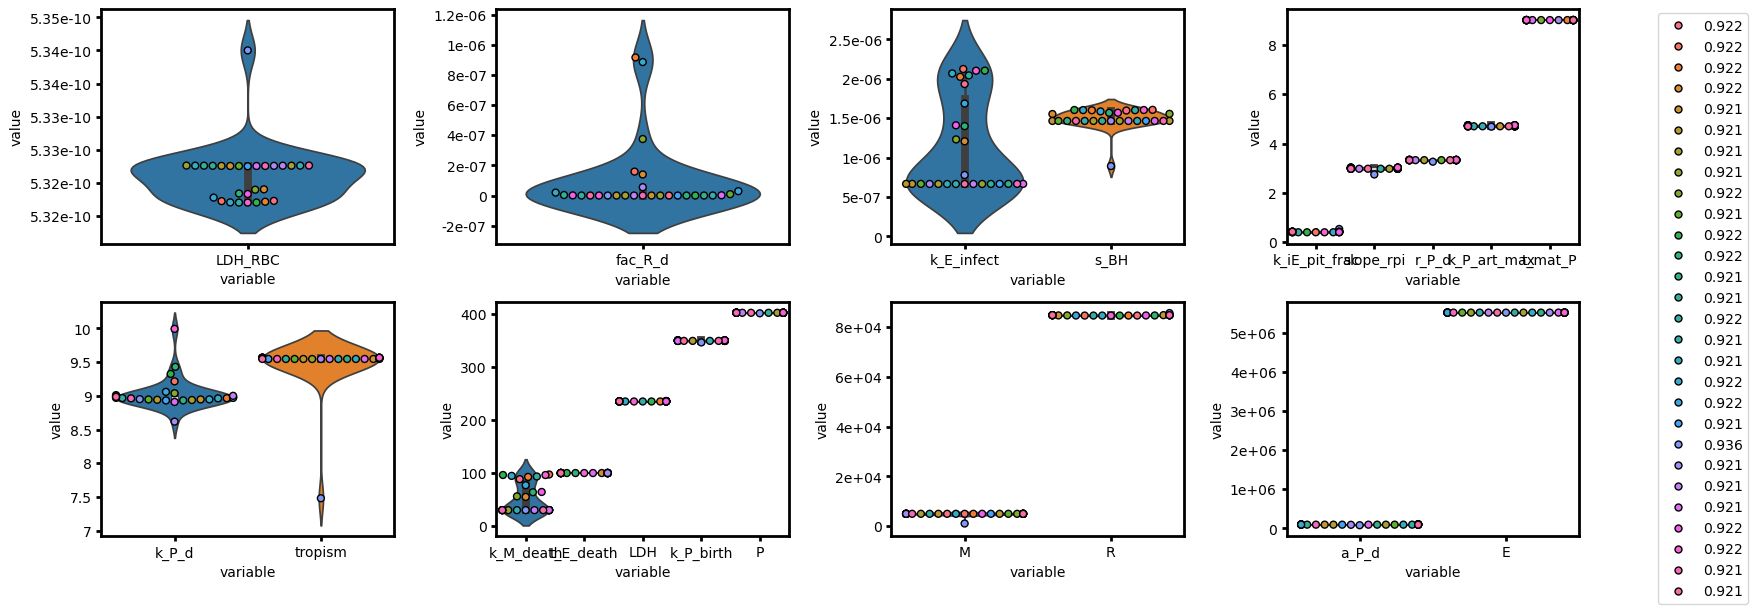

Index(['LDH_RBC', 'k_E_infect', 's_BH', 'par2_fHb', 't_halb_HCC_decay',
       'fac_R_d', 'k_iE_pit_frac', 'r_P_d', 't_halb_HP_decay', 'k_P_art_max',
       'slope_rpi', 'tropism', 't_mat_P', 'k_P_d', 'k_M_death', 't_E_death',
       'LDH', 'k_P_birth', 'P', 'M', 'switch_fHb', 'par1_fHb', 'a_P_d', 'R',
       'E'],
      dtype='object')


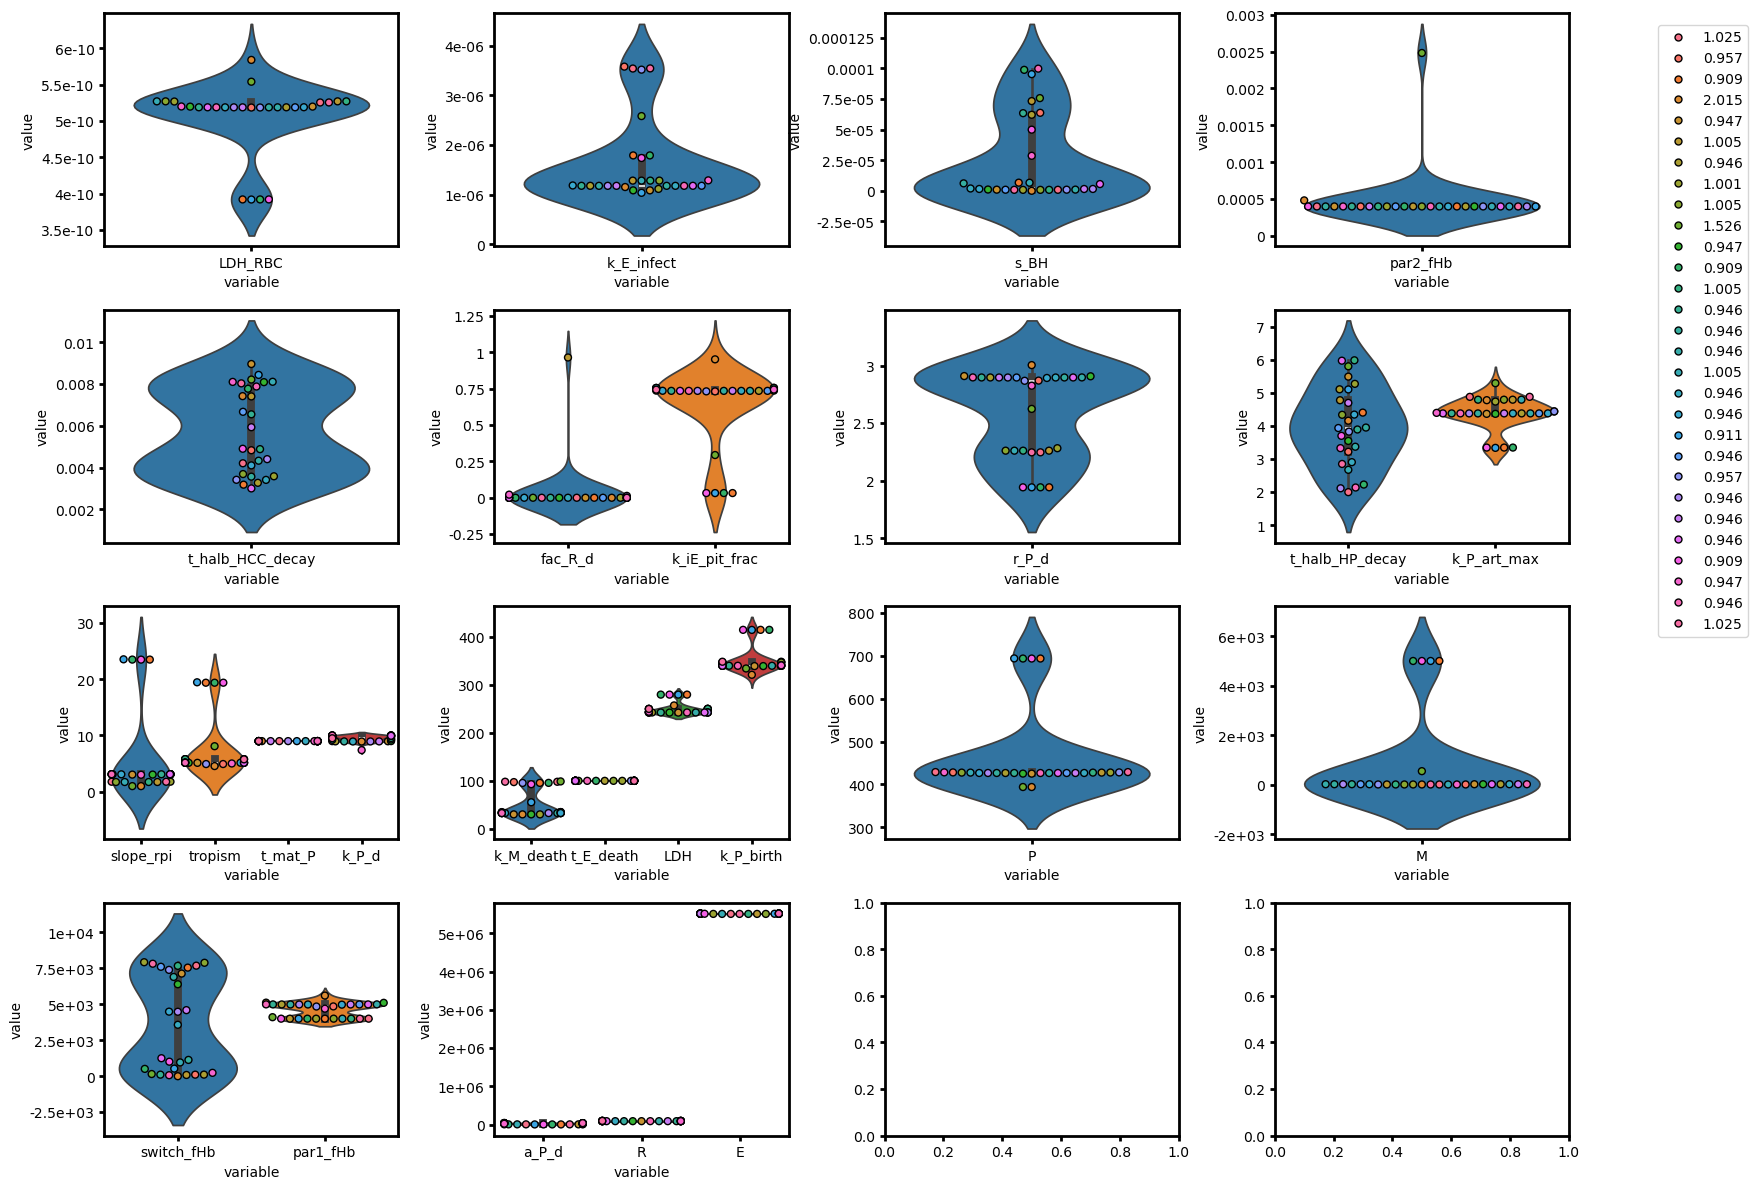

Index(['k_digest_R', 'LDH_RBC', 'k_digest_E', 'epsilon', 'k_E_infect',
       'fac_R_d', 'k_digest_iE', 'beta_Treg', 'beta_in_Treg', 'mu_tox',
       'delta_Ttox', 'V_f', 'k_iE_pit_frac', 'k_P_d', 'slope_rpi',
       'k_P_art_max', 'tropism', 'r_P_d', 't_mat_P', 'M', 'K_f', 'k_M_death',
       'delta_Treg', 'mu_in_tox', 't_E_death', 'LDH', 'P', 'k_P_birth', 'Treg',
       'Ttox', 'R', 'a_P_d', 'E'],
      dtype='object')


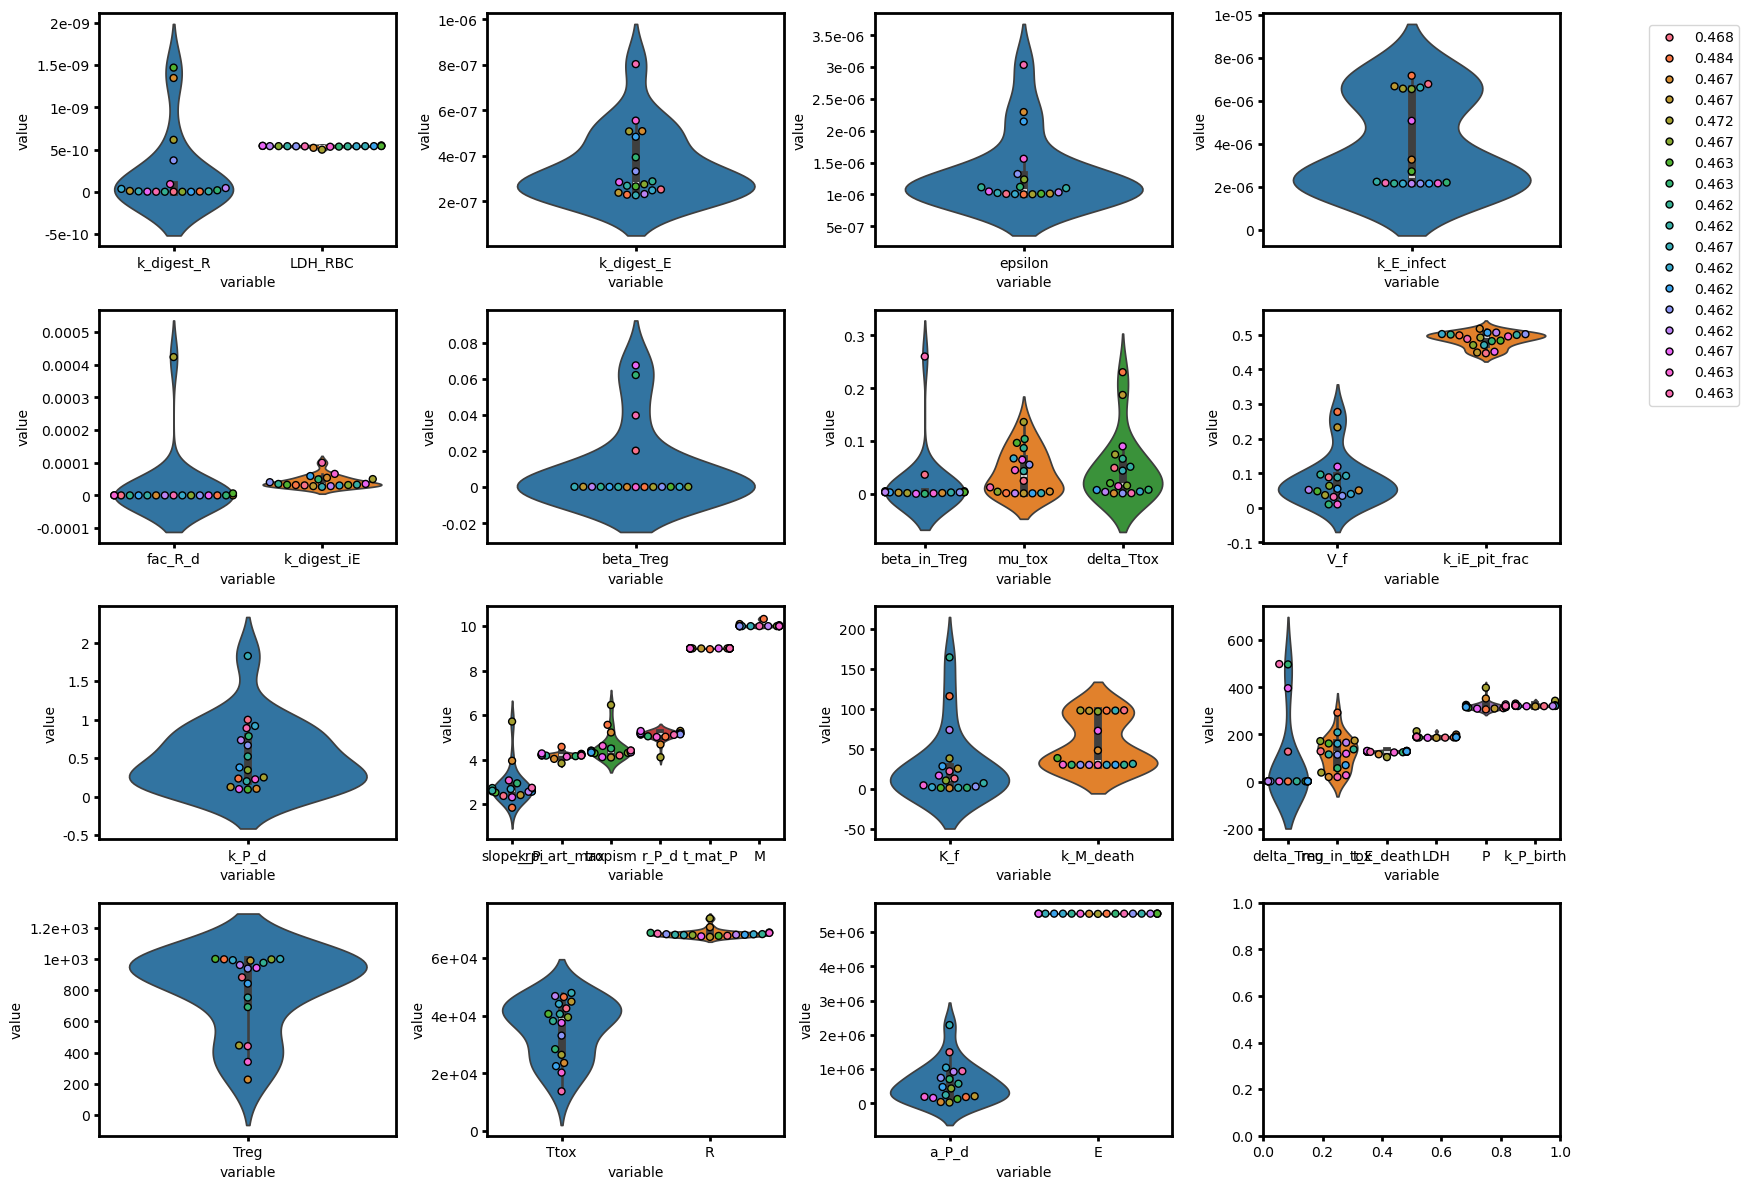

In [10]:
for dfp in pth_ar:
    df = dfp.T
    # Get column groups based on data ranges
    column_groups = categorize_columns(df)

    # Plotting boxplots in subplots
    n_cols = 4
    n_rows = int(np.ceil(len(column_groups)/n_cols))  

    fig, axes = plt.subplots(n_rows, n_cols, squeeze=True, figsize=(n_cols*4, n_rows*3))
    # Custom colors for boxplot elements

    for i, columns in enumerate(column_groups):
        df_boxplot = df[columns].copy()  # Make a copy of the subset DataFrame
        df_boxplot['num']=df_boxplot.index
        melted_df = pd.melt(df_boxplot, id_vars='num',value_vars=df_boxplot.columns)  # Update value_vars with your column names
        
        ax = axes.flatten()[i]

        # Plot violin plot
        sns.violinplot(data=df_boxplot, ax=ax,)
        # Plot swarm plot with hue based on numeric index
        swarm = sns.swarmplot(data=melted_df, ax=ax, x='variable',y='value', hue='num', edgecolor='black', linewidth=1,)
        if i==0:
            # Collect handles and labels for legend
            handles, labels = swarm.get_legend_handles_labels()
            labels = [f'{float(x):,.3f}' for x in labels]
            ax.get_legend().remove()
        else:
            ax.get_legend().remove()
        # Format y-axis labels
        ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.3g}'))
        # Turn off grid lines
        ax.grid(False)

    plt.tight_layout()
    
    fig.legend(handles=handles, labels=labels, loc='upper right', bbox_to_anchor=(1.1, 0.98))

    plt.show()

data = dfp.T
params = dfp.T.columns.tolist()
str_pth = '_pth'
for para in params: 

    has_borders = para in border.keys() or para+str_pth in border.keys()
    border_name = para
    if para+str_pth in border.keys():
        border_name=para+str_pth

    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1], wspace=0)
    # Create a new figure and GridSpec layout
    fig = plt.figure(figsize=(4, 3))

    # Boxplot section (top-left)
    ax_boxplot = fig.add_subplot(gs[0])

    # Plot boxplots for params_group1
    data[[para]].boxplot(ax=ax_boxplot, vert=True, 
                        showmeans=True, meanline=True, showfliers=False, patch_artist=True, #notch=True,
                        boxprops=dict(linewidth=0, facecolor='lightgrey'), medianprops=dict(linewidth=2),
                        whiskerprops=dict(ls='dotted', linewidth=2), capprops=dict(linewidth=2),
                        flierprops=dict(markersize=8), meanprops=dict(linewidth=2))
    #if has_borders:
    #    fig.suptitle(f'Boxplot estimation values of {para}')
    #else:
    #    fig.suptitle(f'Boxplot calculated values of {para}')
   
    ax_boxplot.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.3g}'))
    ax_boxplot.grid(False)
    # Add mean and median to legend
    handles, labels = ax_boxplot.get_legend_handles_labels()
    
    median_handle = plt.Line2D([0], [0], color='#ff7f0e', linewidth=2, label='Median')
    mean_handle = plt.Line2D([0], [0], ls='--', color='#2ca02c', linewidth=2, label='Mean')
    data_handle = plt.Line2D([0],[0], markersize=4,marker='.', c='r', alpha=0.5, label='Values', lw=0)
    
    handles.extend([median_handle, mean_handle, 
                    data_handle
                    ])
    
    # Add border if exists to legend
    if has_borders: 
        border_handle = plt.Line2D([0], [0], ls='--', color='red', linewidth=2, label='Borders')
        handles.extend([border_handle])
    
    #ax_boxplot.legend(handles=handles,)    
    
    # Line plot section (top-right)
    ax_lineplot = fig.add_subplot(gs[1])
    log = False

    if has_borders:
        # Plot line plot for borders
        for param, (lower, upper, log) in border.items():
            if border_name == param:
                ax_lineplot.axhline([lower], linewidth=2, xmin=0.25, xmax=.75,color='r', ls="--")
                ax_lineplot.axhline([upper], linewidth=2, xmin=0.25, xmax=.75,color='r', ls="--")
                data[[para]].boxplot(ax=ax_lineplot, vert=True, 
                                     showmeans=True, meanline=True, showfliers=False, patch_artist=True, #notch=True,
                                     boxprops=dict(linewidth=0, facecolor='lightgrey'), medianprops=dict(linewidth=2),
                                     whiskerprops=dict(ls='dotted', linewidth=2), capprops=dict(linewidth=2),
                                     flierprops=dict(markersize=3), meanprops=dict(linewidth=2))
                
    #make red dots and lable each data point
    for i in range(len(data[[para]])):
        y = data[[para]].iloc[i]
        # Add some random "jitter" to the x-axis
        jitter = 0.002
        if has_borders: jitter=0.04
        x = np.random.normal(1, jitter, size=len(y))
        ax_lineplot.plot(x, y, 'r.', alpha=0.5, markersize=4)
        #for ids, txt in enumerate(y):
            #_ = plt.text(x[ids]+0.03*x[ids], y[ids]-0.01*y[ids],ids)
    if not has_borders:
        ax_lineplot.set_xlim(.98,1.02)
    # Adjust plot
    say = ax_lineplot.secondary_yaxis('right')
    say.yaxis.set_visible('Border Value')
     # Formatting for the line plot OBJECT   
    if log: ax_lineplot.set_yscale('log')
    else: ax_lineplot.set_yscale('linear')           
    
    ax_lineplot.grid(False)
    ax_lineplot.yaxis.set_visible(False)
    ax_lineplot.xaxis.set_visible(False)
    say.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.3g}'))
    x_anchor = -3.5
    if not has_borders: x_anchor=-2.75
    plt.legend(handles=handles, ncols=len(handles), bbox_to_anchor=(x_anchor, 1),loc='lower left', fontsize='small')
    # Adjust spacing
    #plt.tight_layout()

    plt.show()


### Patient estimation plots

In [61]:
path = '../Estimation/general'
df_lst =[]
data = pd.read_csv('../datasets/OIE_data.csv')
df_sed = []
dir_locs = ['101', '102', '105', '106', '107', '108', '110', '111', '20', '27',
        '33', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45',
        '46', '47', '48', '49', '50', '51', '52', '53', '54', '57', '58',
        '59', '60', '61', '63', '66', '67', '68', '70', '71', '72', '73',
        '74', '75', '76', '80', '81', '82', '83', '86', '87', '88', '89',
        '90', '94', '95', '98', '99',]
for ele in dir_locs:
        for key in ['non_pth', 'pth']:
                key1 = key
                if key == 'non_pth':
                        key1 = 'non'
                print(FitManager(ele, 'general').objective_function(get_parameter_sets(d_path='../Estimation/general', 
                                                                                 dir=key+'/patient'+ele, 
                                                                                 best=True), key1))
        #print(FitManager(ele,'general').objective_function(get_parameter_sets(d_path='../Estimation/general', dir='non_pth/patient'+ele, best=True),'non'))
        #print(FitManager(ele,'general').objective_function(get_parameter_sets(d_path='../Estimation/general', dir='pth/patient'+ele, best=True),'pth'))

        n_df = get_parameter_sets(path, f'non_pth/patient{ele}')
        immunity = data[data['patientnumber']==ele]['Groups'].unique()[0]
        for v in n_df.columns:
                df_lst.append({f'patient':f'patient{ele}', 'Pth':0,
                                'values':float(v), 'immunity': immunity})
        pth_df = get_parameter_sets(path, f'pth/patient{ele}')
        print(ele)
        df_sed.append({f'patient':ele, 'Pth':1,'values':float(sorted(pth_df.columns)[0])}|pth_df[sorted(pth_df.columns)[0]].to_dict())
        for v in pth_df.columns:
                df_lst.append({f'patient':f'patient{ele}', 'Pth':1,
                                'values':float(v), 'immunity': immunity})

score_df = pd.DataFrame(df_lst)

Best score=4.083705953888423
{'non': 2.0418529769402323}
Best score=4.083705953888423
{'pth': 2.0418529769481903}
101
Best score=0.10963904529908566
{'non': 0.05571516927051288}
Best score=0.10963904529908566
{'pth': 0.053923876028572786}
102
Best score=2.1810331755292376
{'non': 1.0906388890258452}
Best score=2.1810331755292376
{'pth': 1.0903942865033927}
105
Best score=3.0167122784562874
{'non': 1.5084259584438355}
Best score=3.0167122784562874
{'pth': 1.5082863200124517}
106
Best score=0.5339384030824238
{'non': 0.26696920154153}
Best score=0.5339384030824238
{'pth': 0.2669692015408938}
107
Best score=0.5304678366881188
{'non': 0.265233918344877}
Best score=0.5304678366881188
{'pth': 0.26523391834324184}
108
Best score=2.1829679229486594
{'non': 1.0918362361087002}
Best score=2.1829679229486594
{'pth': 1.0911316868399594}
110
Best score=0.7406639393576977
{'non': 0.37033196977263344}
Best score=0.7406639393576977
{'pth': 0.3703319695850643}
111
Best score=1.2134711455475928
{'non': 

In [83]:
df_para = pd.DataFrame(df_sed)
df_para = df_para.set_index('patient')

In [63]:
df_heat = df_para[df_para['values']<=3.0]/pth_ar[0][sorted(pth_ar[0].columns)[0]]
df_heat = df_heat.dropna(axis=1)
df_heat.max()
df_log2 = df_heat.copy()
for c in df_heat.select_dtypes(include = [np.number]).columns:
    df_log2[c] = np.log2(df_heat[c].values)

In [64]:
from matplotlib.colors import BoundaryNorm, ListedColormap

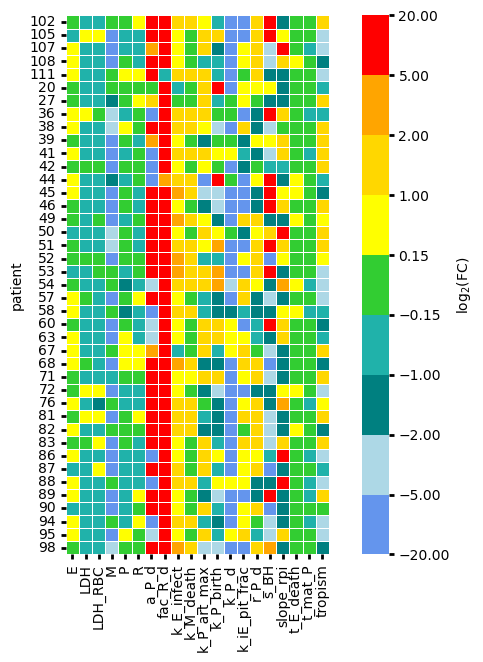

In [65]:
my_colors = ['cornflowerblue','lightblue','teal','lightseagreen','limegreen','yellow', 'gold', 'orange', 'red',]
my_cmap = ListedColormap(my_colors)
bounds = [-20, -5, -2,-1,-0.15,0.15, 1, 2,5, 20]
my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))
fig, ax = plt.subplots(figsize=(8.5,7.))
sns.heatmap(data=df_log2, square=True,xticklabels=True, yticklabels=True,
            cmap=my_cmap, linewidth=0.5,
            ax=ax,
            norm=my_norm
            )
ax.collections[0].colorbar.set_label("log$_2$(FC)")
#plt.savefig('patient_scores.pdf',bbox_inches='tight' )

In [66]:
df_heat.index
n_data = pd.read_csv('../datasets/OIE_data.csv')


In [67]:
row_colors = []
luts =[]
for i,col in enumerate(['Groups', 'Ethnicity','sex', 'PTH', 'age','malclass',]):#'malclass', 'PTH', 'age', 'sex', 'Ethnicity', 
    lut = dict(zip(n_data[col].unique(), 
                   sns.cubehelix_palette(len(n_data[col].unique()), 
                                         start=i*0.5, hue=1, rot=-.1
                                         ).as_hex())
                )
    luts.append(lut)
    row_colors.append(pd.DataFrame(index=df_heat.index, columns=[col],
                            data=[lut.get(n_data[n_data['patientnumber']==x].iloc[0][col]) for x in df_heat.index]))

In [68]:
row_colors_p = pd.concat([row_colors[x] for x in range(4)],axis=1)

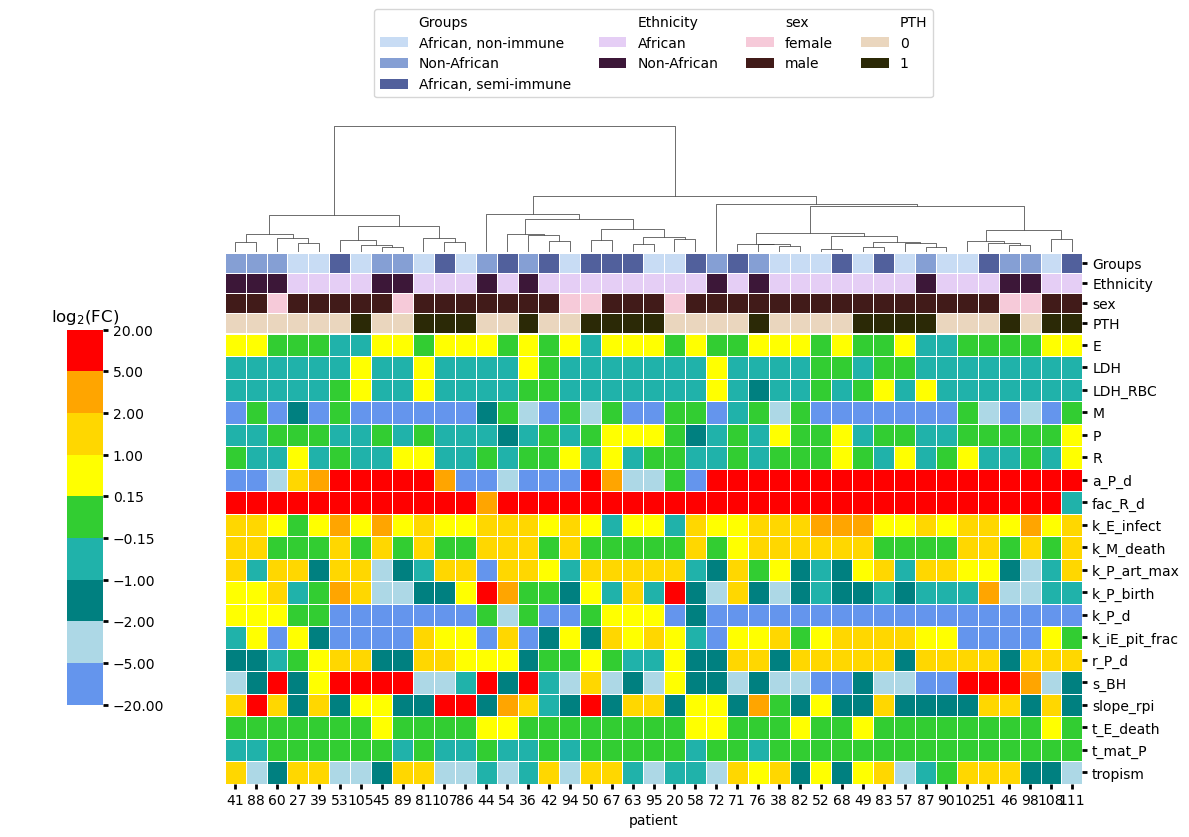

In [69]:
g = sns.clustermap(data=df_log2.T,method='ward', 
                   #center=0, 
                   robust=True, xticklabels=True, yticklabels=True, 
                   #z_score=0, 
                   cmap=my_cmap, 
                   norm=my_norm,
                   figsize=(12,7.5),
                   col_colors=row_colors_p, row_cluster=False,
                   linewidth=0.5)

g.ax_cbar.set_position([0.06, 0.2, 0.03, 0.5])
g.ax_cbar.set_title('log$_2$(FC)')#"log$_2$(FC)"
g.ax_cbar.tick_params(axis='x', length=10)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=0) # For x axis
# add legends
for i, col in enumerate(['Groups','Ethnicity','sex', 'PTH']):
    for j,label in enumerate(luts[i].keys()):
        
        if type(label)==float:
            continue
        if j==0:
            g.ax_col_dendrogram.bar(0, 0, color='white', label=col, linewidth=0)
        g.ax_col_dendrogram.bar(0, 0, color=luts[i][label], label=label, linewidth=0)
l1 = g.ax_col_dendrogram.legend( loc="center", ncol=4, bbox_to_anchor=(0.5, 1.5), )#bbox_transform=gcf().transFigure)
plt.savefig('patient_clustermap.pdf',bbox_inches='tight' )
fig.tight_layout()

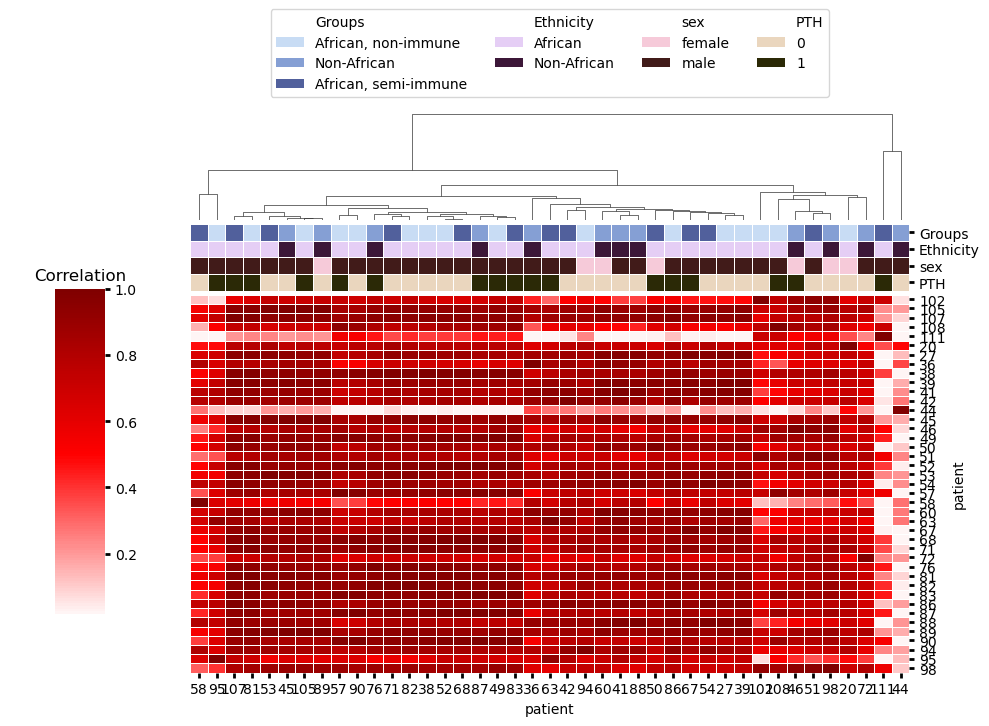

In [70]:
g = sns.clustermap(data=df_log2.T.corr(), cmap='seismic', center=0, #method='ward',
                    robust=True, xticklabels=True, yticklabels=True, 
                    figsize=(10,6.5),
                    row_cluster=False,
                    col_colors=row_colors_p,
                    linewidth=0.5)

g.ax_cbar.set_position([0.06, 0.2, 0.05, 0.5])
g.ax_cbar.set_title('Correlation')
g.ax_cbar.tick_params(axis='x', length=10)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=0) # For x axis
# add legends
for i, col in enumerate(['Groups','Ethnicity','sex', 'PTH']):
    for j,label in enumerate(luts[i].keys()):
        
        if type(label)==float:
            continue
        if j==0:
            g.ax_col_dendrogram.bar(0, 0, color='white', label=col, linewidth=0)
        g.ax_col_dendrogram.bar(0, 0, color=luts[i][label], label=label, linewidth=0)
l1 = g.ax_col_dendrogram.legend( loc="center", ncol=4, bbox_to_anchor=(0.5, 1.5), )#bbox_transform=gcf().transFigure)

fig.tight_layout()

### Plots patient scores 

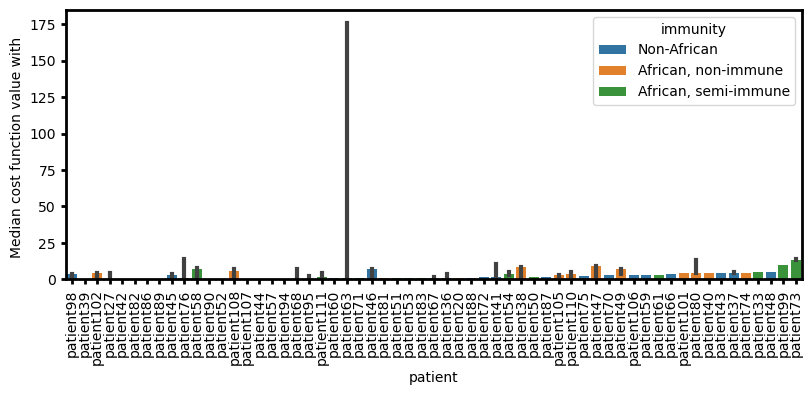

In [84]:
data = score_df.groupby(['patient','immunity']).median(numeric_only=True).sort_values(by='values')
fig, axs = plt.subplots(figsize=(9.5, 3.5))

sns.barplot(data=score_df.sort_values(by='values'),x='patient',y='values', hue='immunity',
            ax=axs,
            errorbar="ci", estimator="median")
axs.tick_params(axis='x', labelrotation=90)
axs.set_ylabel('Median cost function value with ')
plt.show()

In [72]:
order = score_df.sort_values(by='values')['patient'].unique()

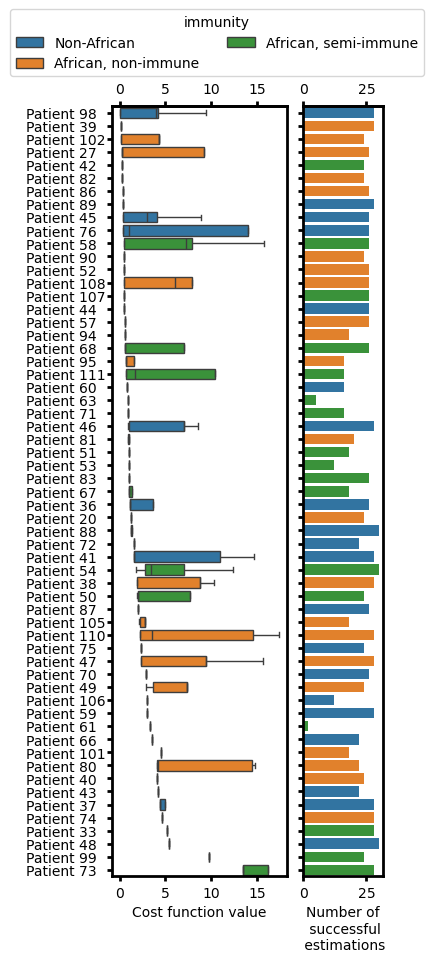

In [85]:
fig, axs = plt.subplot_mosaic([['cs_val','cs_val', 'es_val']], sharey=True, figsize=(3.5,10))

sns.boxplot(data=score_df.sort_values(by='values'),y='patient',x='values', hue='immunity',
            ax=axs['cs_val'], 
            showfliers=False,
            legend=True,
            )
            #errorbar="ci", estimator="median")
sns.move_legend(axs['cs_val'], "lower center", bbox_to_anchor=(.6, 1.03), ncol=2)

axs['cs_val'].set_xlabel('Cost function value')
axs['cs_val'].secondary_xaxis(location='top')

axs['cs_val'].tick_params(axis='y',pad=58) 
axs['cs_val'].set_ylabel('')
label = [item.get_text().replace('p','P') for item in axs['cs_val'].get_yticklabels()]
label = [item[:7]+' '+item[7:] for item in label]
axs['cs_val'].set_yticklabels(label, ha='left')

data1 = score_df.groupby(['patient', 'immunity']).count().sort_values(by='Pth')
data1 = data1.reset_index(level='immunity')

# has same order as patient cost function plot
sns.barplot(data=data1.reindex(order), x='values', y='patient', hue='immunity',
            ax=axs['es_val'], legend=False )
axs['es_val'].set_xlabel('Number of\n successful\n estimations')
axs['es_val'].secondary_xaxis(location='top')
axs['es_val'].set_ylabel('')
plt.savefig('patient_scores.pdf',bbox_inches='tight' )

Text(0, 0.5, '')

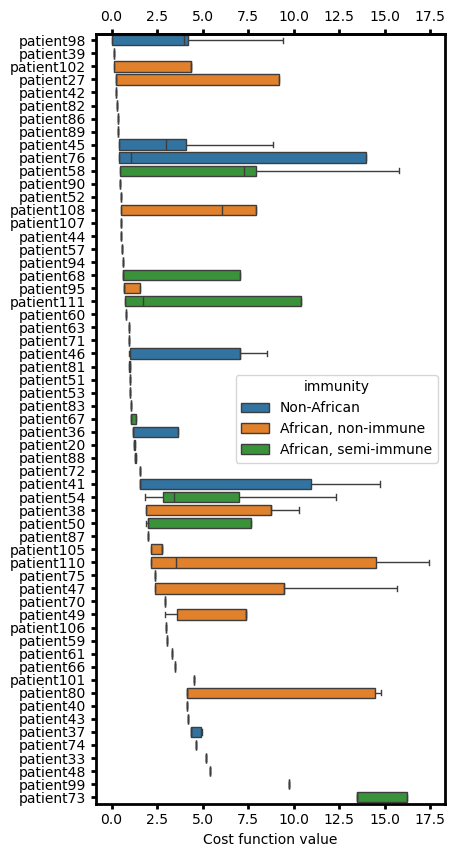

In [74]:
fig, axs = plt.subplots(figsize=(4.5,10.))

sns.boxplot(data=score_df.sort_values(by='values'),y='patient',x='values', hue='immunity',
            ax=axs, 
            showfliers=False
            )
            #errorbar="ci", estimator="median")
#axs.tick_params(axis='x', labelrotation=90)
axs.set_xlabel('Cost function value')
axs.secondary_xaxis(location='top')
axs.set_ylabel('')

Text(0, 0.5, 'Median cost function value')

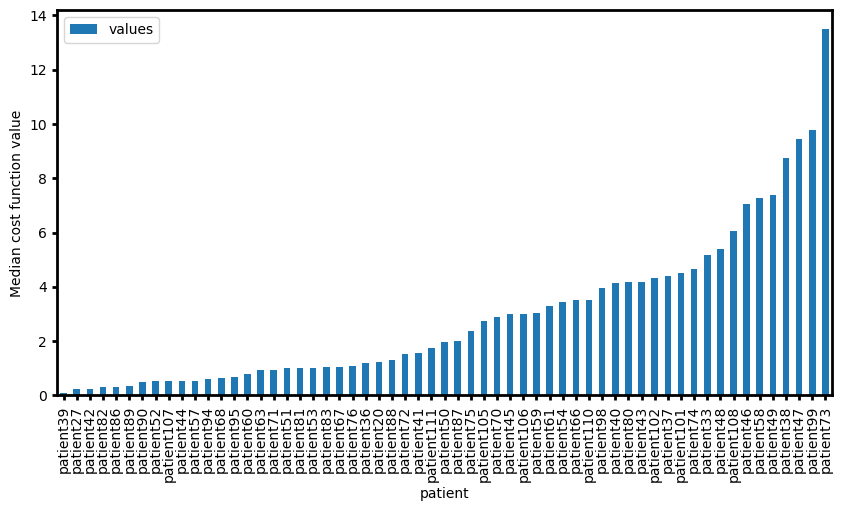

In [75]:
fig, axs = plt.subplots()
score_df.groupby(['patient']).median(numeric_only=True).sort_values(by='values').plot(kind='bar', y ='values', ax=axs,figsize=(10,5),
                                                                                      )
axs.set_ylabel('Median cost function value')

### Plots amount of estimation data points

Text(0.5, 0, 'Number of successful estimations')

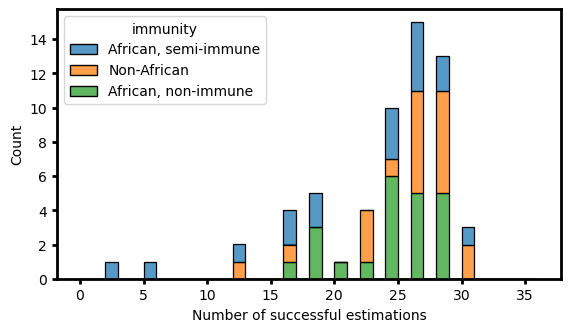

In [76]:
fig, axs = plt.subplots( figsize=(6.5, 3.5))

data1 = score_df.groupby(['patient', 'immunity']).count().sort_values(by='Pth')
sns.histplot(data=data1,x='values', hue='immunity', ax=axs, multiple='stack', bins=np.arange(0,37,1))
axs.set_xlabel('Number of successful estimations')

Text(0, 0.5, '')

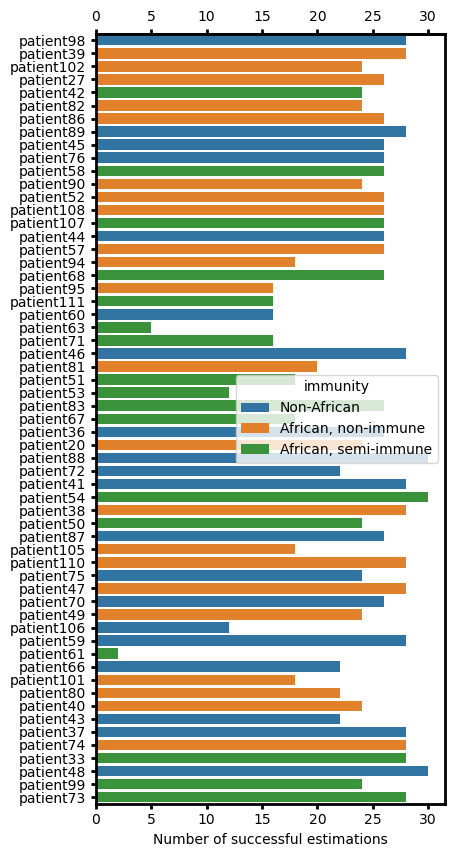

In [77]:
data1 = data1.reset_index(level='immunity')
# has same order as patient cost function plot
fig, axs = plt.subplots( figsize=(4.5, 10.0))


sns.barplot(data=data1.reindex(order), x='values', y='patient', hue='immunity', ax=axs, )
axs.set_xlabel('Number of successful estimations')
axs.secondary_xaxis(location='top')
axs.set_ylabel('')

In [78]:
df_immune_lst = []
for immue in score_df['immunity'].unique():
    hist, bin_edges = np.histogram(data1[data1['immunity']==immue]['values'],
                                bins=[(n+1)*2 for n in range(15)]+[50])#np.arange(0,36,n_groups))

    labels  = [f'[{bin_edges[i]:.0f}, {bin_edges[i+1]:.0f}[' for i in range(len(bin_edges)-1)]
    #plt.pie(hist, labels=labels,autopct='%1.1f%%',
            #colors=plt.cm.viridis(np.linspace(0.4,0.9,len(bin_edges))))#plt.cm.Dark2(np.arange(0,n_groups+1,))) #plt.cm.blues(np.linspace(0,1,n_groups+1,)
    #plt.show()
    for i,value in enumerate(hist):
        df_immune_lst.append({'immunity':immue+' n_p='+str(sum(hist)),'value': value,'border':bin_edges[i]})

In [79]:
df_nex = pd.DataFrame(df_immune_lst)
df_nex = df_nex.pivot(index='border',columns='immunity', values='value')
df_nex = df_nex/df_nex.sum()
col = df_nex.columns.to_list()
df_nex['Number of estimations']=labels
cols = df_nex.columns.tolist()
df_nex = df_nex[cols[-1:]+cols[:-1]]
print(df_nex.style.format("{:.1%}", subset=col).to_latex())
df_nex

\begin{tabular}{llrrr}
immunity & Number of estimations & African, non-immune n_p=22 & African, semi-immune n_p=17 & Non-African n_p=20 \\
border &  &  &  &  \\
2 & [2, 4[ & 0.0% & 5.9% & 0.0% \\
4 & [4, 6[ & 0.0% & 5.9% & 0.0% \\
6 & [6, 8[ & 0.0% & 0.0% & 0.0% \\
8 & [8, 10[ & 0.0% & 0.0% & 0.0% \\
10 & [10, 12[ & 0.0% & 0.0% & 0.0% \\
12 & [12, 14[ & 0.0% & 5.9% & 5.0% \\
14 & [14, 16[ & 0.0% & 0.0% & 0.0% \\
16 & [16, 18[ & 4.5% & 11.8% & 5.0% \\
18 & [18, 20[ & 13.6% & 11.8% & 0.0% \\
20 & [20, 22[ & 4.5% & 0.0% & 0.0% \\
22 & [22, 24[ & 4.5% & 0.0% & 15.0% \\
24 & [24, 26[ & 27.3% & 17.6% & 5.0% \\
26 & [26, 28[ & 22.7% & 23.5% & 30.0% \\
28 & [28, 30[ & 22.7% & 11.8% & 30.0% \\
30 & [30, 50[ & 0.0% & 5.9% & 10.0% \\
\end{tabular}



immunity,Number of estimations,"African, non-immune n_p=22","African, semi-immune n_p=17",Non-African n_p=20
border,,,,
2,"[2, 4[",0.000000,0.058824,0.00
4,"[4, 6[",0.000000,0.058824,0.00
6,"[6, 8[",0.000000,0.000000,0.00
8,"[8, 10[",0.000000,0.000000,0.00
10,"[10, 12[",0.000000,0.000000,0.00
12,"[12, 14[",0.000000,0.058824,0.05
14,"[14, 16[",0.000000,0.000000,0.00
16,"[16, 18[",0.045455,0.117647,0.05
18,"[18, 20[",0.136364,0.117647,0.00


### Plots values of estimation data

Text(0.5, 0, 'Cost function value')

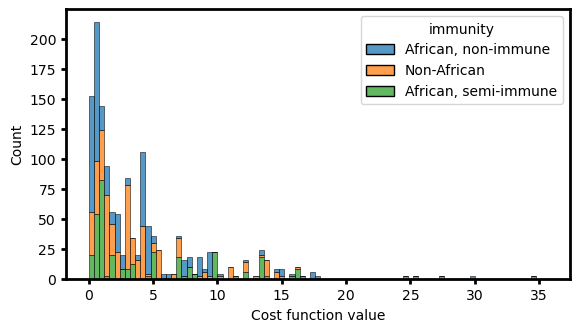

In [80]:
fig, axs = plt.subplots( figsize=(6.5, 3.5))
sns.histplot(score_df,x='values', hue='immunity', ax=axs, multiple='stack', bins=np.arange(0,36,0.4))
axs.set_xlabel('Cost function value')

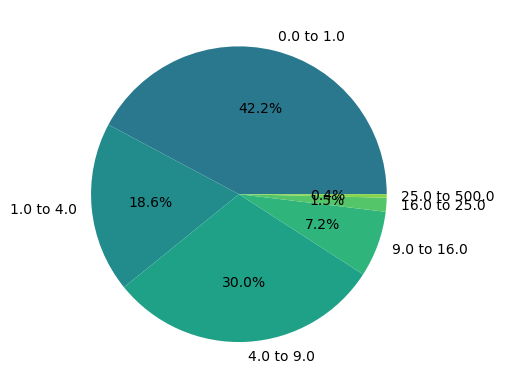

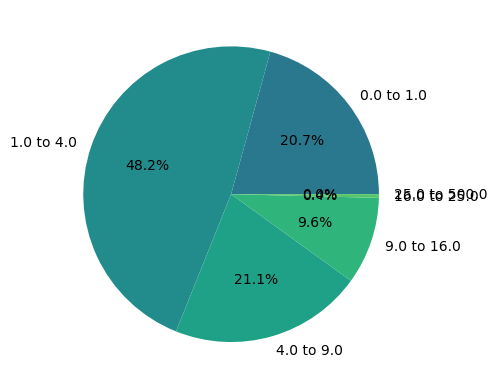

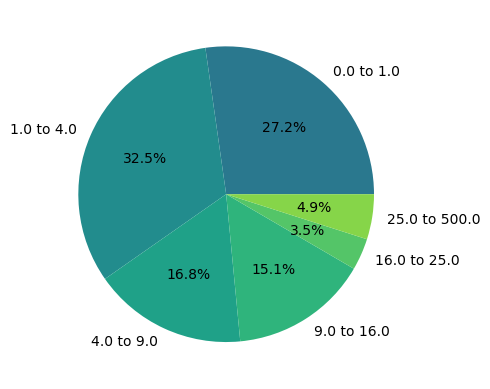

In [81]:
df_immune_lst = []
for immue in score_df['immunity'].unique():
    hist, bin_edges = np.histogram(score_df[score_df['immunity']==immue]['values'],
                                bins=[n**2 for n in range(6)]+[500])#np.arange(0,36,n_groups))

    labels  = [f'{bin_edges[i]:.1f} to {bin_edges[i+1]:.1f}' for i in range(len(bin_edges)-1)]
    plt.pie(hist, labels=labels,autopct='%1.1f%%',
            colors=plt.cm.viridis(np.linspace(0.4,0.9,len(bin_edges))))#plt.cm.Dark2(np.arange(0,n_groups+1,))) #plt.cm.blues(np.linspace(0,1,n_groups+1,)
    plt.show()
    for i,value in enumerate(hist):
        df_immune_lst.append({'immunity':immue+' n='+str(sum(hist)),'value': value,'border':bin_edges[i]})

In [82]:
df_nex = pd.DataFrame(df_immune_lst)
df_nex = df_nex.pivot(index='border',columns='immunity', values='value')
df_nex = df_nex/df_nex.sum()
col = df_nex.columns.to_list()
df_nex['Costscore ranges']=labels
cols = df_nex.columns.tolist()
df_nex = df_nex[cols[-1:]+cols[:-1]]
print(df_nex.style.format("{:.1%}", subset=col).to_latex())
df_nex

\begin{tabular}{llrrr}
immunity & Costscore ranges & African, non-immune n=526 & African, semi-immune n=345 & Non-African n=502 \\
border &  &  &  &  \\
0 & 0.0 to 1.0 & 42.2% & 27.2% & 20.7% \\
1 & 1.0 to 4.0 & 18.6% & 32.5% & 48.2% \\
4 & 4.0 to 9.0 & 30.0% & 16.8% & 21.1% \\
9 & 9.0 to 16.0 & 7.2% & 15.1% & 9.6% \\
16 & 16.0 to 25.0 & 1.5% & 3.5% & 0.4% \\
25 & 25.0 to 500.0 & 0.4% & 4.9% & 0.0% \\
\end{tabular}



immunity,Costscore ranges,"African, non-immune n=526","African, semi-immune n=345",Non-African n=502
border,,,,
0,0.0 to 1.0,0.422053,0.272464,0.207171
1,1.0 to 4.0,0.186312,0.324638,0.482072
4,4.0 to 9.0,0.300380,0.168116,0.211155
9,9.0 to 16.0,0.072243,0.150725,0.095618
16,16.0 to 25.0,0.015209,0.034783,0.003984
25,25.0 to 500.0,0.003802,0.049275,0.000000
